In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
from  sklearn.metrics import mean_squared_error as mse
from sklearn.utils import class_weight
from astropy.io import fits
import matplotlib.pyplot as plt
import os, sys
import time
from sklearn.metrics import confusion_matrix,accuracy_score
from keras.regularizers import l2
from keras.activations import tanh
from keras.models import Sequential
from keras.layers import *
from keras.losses import categorical_crossentropy,binary_crossentropy
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from keras import backend as K
from time import time
from random import shuffle,seed
from sklearn.metrics import classification_report
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.backend import eval
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,f1_score, confusion_matrix, mean_absolute_error,mean_squared_error, median_absolute_error
from sklearn.preprocessing import normalize


def plot_df(df):
    try:
        from IPython.display import display
        display(df)
    except:
        print(df)
    
def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
def calculate_metrics(y_true,y_pred,plot=True, title=""):
    dic_return = {}
    dic_return["Precision raw"] = precision_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["Recall raw"] = recall_score(y_true,y_pred,average=None,labels=[0,1])
    #dic_return["Precision"] = precision_score(y_true,y_pred,average=None,labels=[0,1])
    #dic_return["Recall"] = recall_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["F1 raw"] = f1_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["F1 weighted"] = f1_score(y_true,y_pred,average="weighted",labels=[0,1])
    dic_return["F1 macro"] = f1_score(y_true,y_pred,average="macro",labels=[0,1])
    dic_return["F1 micro"] = f1_score(y_true,y_pred,average="micro",labels=[0,1])
    matriz=confusion_matrix(y_true,y_pred, labels=[0,1])
    if plot:
        df = pd.DataFrame(dic_return)
        df.index = ["False Positive","Confirmed"]
        plot_df(df)
        plot_confusion_matrix(normalize(matriz,axis=1,norm='l1'),["False Positive","Confirmed"],title)
    dic_return["Confusion Matrix"] = matriz
    return dic_return


def calculate_median_abs_err(real, pred): 
    if len(real.shape) > 1:
        return np.mean([median_absolute_error(real[:,d],pred[:,d]) for d in range(real.shape[1])])   
    else:
        return median_absolute_error(real,pred)
    
def calculate_mean_abs_perce_err(real, pred):
    diff = np.abs((real - pred) / np.clip(np.abs(real), 1e-7, None))
    return 100. * np.mean(diff) #sin *100 es "fractional"

def calculate_Rmean_squar_log_err(real, pred):
    first_log = np.log(np.clip(pred, 1e-7, None) + 1.)
    second_log = np.log(np.clip(real, 1e-7, None) + 1.)
    return np.sqrt(np.mean(np.square(first_log - second_log)))

def evaluate_metadata(real, pred, plot=False):
    dic_res = {}
    dic_res["MSE"] = mean_squared_error(real, pred)
    dic_res["MAE"] = mean_absolute_error(real, pred)
    dic_res["MeAE"] = calculate_median_abs_err(real, pred)
    dic_res["MApE"] = calculate_mean_abs_perce_err(real,pred)
    dic_res["RMSLE"] = calculate_Rmean_squar_log_err(real,pred)
    if plot:
        df = pd.DataFrame(dic_res)
        df.index = ["Real"]
        plot_df(df)
    return dic_res

def evaluate_metadata_raw(real, pred, plot=True, metadata_used=[""]):
    mse_raw = []
    mae_raw = []
    mEae_raw = []
    maPe_raw = []
    rmsle_raw = []
    for d in range(real.shape[1]):        
        dic_aux = evaluate_metadata(real[:,d], pred[:,d], plot=False)
        mse_raw.append(dic_aux["MSE"])
        mae_raw.append(dic_aux["MAE"])
        mEae_raw.append(dic_aux["MeAE"])
        maPe_raw.append(dic_aux["MApE"])
        rmsle_raw.append(dic_aux["RMSLE"])
        
    res_metadata = {}
    res_metadata["MSE"] = mse_raw
    res_metadata["MAE"] = mae_raw
    res_metadata["MeAE"] = mEae_raw
    res_metadata["MApE"] = maPe_raw
    res_metadata["RMSLE"] = rmsle_raw
    
    if plot:
        df = pd.DataFrame(res_metadata)
        df.index = metadata_used
        df.loc["Global"] = np.mean(df, axis=0)
        plot_df(df.transpose())
    res_metadata["MSE"].append(np.mean(mse_raw))
    res_metadata["MAE"].append(np.mean(mae_raw))
    res_metadata["MeAE"].append(np.mean(mEae_raw))
    res_metadata["MApE"].append(np.mean(maPe_raw))
    res_metadata["RMSLE"].append(np.mean(rmsle_raw))
    return res_metadata


import keras
from keras.callbacks import Callback,ModelCheckpoint, ReduceLROnPlateau
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []

    def on_epoch_end(self, batch, logs={}):
        predict = np.squeeze(self.model.predict_classes(self.validation_data[0]))
        targ = np.squeeze(self.validation_data[1])
        f1s = f1_score(targ, predict, average='macro')
        self.val_f1s.append(f1s)
        print(" - val_f1: %f " %(f1s))
        return

import tensorflow as tf
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

def train_model(aux_model, x_train, y_train, x_val, y_val, e=25, BS=128, focal=False, verbose=False,alpha=0.6,save_f='best_mod.hdf5'):
    if focal:
        aux_model.compile(loss=binary_focal_loss(alpha=alpha, gamma=2),optimizer='Adam',metrics=['accuracy'])
    else:
        aux_model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
    
    calls = []
    metrics = Metrics()
    calls.append(metrics)
    mcp_save = ModelCheckpoint(save_f, save_best_only=True, monitor='val_loss', mode='min')
    calls.append(mcp_save)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode ='min',factor=0.2,patience=10, min_lr=0.001)
    if not focal:
        calls.append(reduce_lr)
    hist=aux_model.fit(x_train, y_train, batch_size=BS, epochs=e, verbose=verbose, validation_split=0.1,#validation_data=(x_val,y_val),
                      callbacks=calls)
    
    plt.figure(figsize=(8,4))
    plt.plot(hist.history['loss'],label="train_loss")
    plt.plot(hist.history['val_loss'],label="val_loss")
    plt.title("Model Loss BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(hist.history['acc'],label="Train accuracy" )
    plt.plot(hist.history['val_acc'],label="Val accuracy" )
    plt.title("Model Accuracy BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()
    
    plt.figure(figsize=(8,4))
    if not focal:
        plt.plot(hist.history['val_loss'],label="loss" )
    plt.plot(hist.history['val_acc'],label="accuracy" )
    plt.plot(metrics.val_f1s,label="F1" )
    plt.ylabel("Metric")
    plt.xlabel('Epochs')
    plt.title("Test set/val")
    plt.legend(loc="upper left")
    plt.show()
    

Using TensorFlow backend.


### Sólo un canal (izq-der)

In [2]:
df_sets = pd.read_csv("../../KOI_Data/koi_sets.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values   #validation
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values
df_sets.head()

KOI Name        Set
0  K00889.01      Train
1  K01009.01      Train
2  K07621.01       Test
3  K06252.01       Test
4  K00958.01  Unlabeled

In [3]:
df_meta = pd.read_csv("../../KOI_Data/koi_metadata.csv")
df_meta_train = df_meta[mask_train]
df_meta_test = df_meta[mask_test]
df_meta_unb = df_meta[mask_unlabeled]
df_meta_train.head()

KOI Name NExScI Disposition   Kepler Name      Period  \
0   K00889.01          CONFIRMED   Kepler-75 b    8.884923   
1   K01009.01     FALSE POSITIVE           NaN    5.092465   
7   K07622.01     FALSE POSITIVE           NaN   36.267167   
9   K00998.01     FALSE POSITIVE           NaN  161.788327   
10  K00992.01          CONFIRMED  Kepler-745 b    9.931463   

    Time of Transit Epoch  First Transit Time (BJD)  Impact Parameter  \
0              169.991686               2455002.992             0.069   
1              357.535940               2455190.536             0.161   
7              155.081300               2454988.081             0.214   
9              214.039000               2455047.039             0.267   
10             136.491280               2454969.491             0.037   

    Duration  Transit Depth    r/R  ...    Teff  log(g)  Metallicity  \
0    2.07004        16053.4  0.114  ...  5332.0   4.500        -0.08   
1    3.65900          254.0  0.014  ...  5037.0   4.547        -0.20   
7    2.06500          627.1  0.022  ...  4264.0   4.637        -0.20   
9    5.31000        87750.0  0.273  ...  6018.0   4.327         0.18   
10   5.67800          398.6  0.018  ...  5782.0   4.280         0.16   

    Stellar Radius  Stellar Mass  Max single event sigma  \
0            0.843         0.821                  61.291   
1            0.751         0.727                   3.648   
7            0.620         0.607                   3.016   
9            1.212         1.142                 341.666   
10           1.220         1.035                   4.530   

    Max Multievent sigma  Transit Model SNR  KOI count  Transit Number  
0                474.021              388.2          1             153  
1                 15.175               17.1          1             225  
7                  7.472               10.0          1              39  
9                806.993              704.5          1               9  
10                22.901               26.2          2             137  

[5 rows x 31 columns]

In [4]:
df_meta_train.shape

(4339, 31)

In [5]:
df_meta_test.shape

(1918, 31)

In [6]:
df_meta_unb.shape

(1797, 31)

In [7]:
y_train= (df_meta_train['NExScI Disposition'].values=="CONFIRMED")*1
y_val = (df_meta_test['NExScI Disposition'].values=="CONFIRMED")*1

unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_val, counts_val = np.unique(y_val, return_counts=True)

print('y_train distribution: 0:%i   1:%i'%(counts_train[0],counts_train[1]))
print('y_val distribution:   0:%i   1:%i'%(counts_val[0],counts_val[1]))

y_train distribution: 0:2729   1:1610
y_val distribution:   0:1247   1:671


In [8]:
df_meta_train.shape

(4339, 31)

## Modelo 1

### BCE

Entrenando usando representación 	Up: 15   Down: 15
 - val_f1: 0.621146 
 - val_f1: 0.716895 
 - val_f1: 0.686904 
 - val_f1: 0.712914 
 - val_f1: 0.708487 
 - val_f1: 0.690789 
 - val_f1: 0.691008 
 - val_f1: 0.585696 
 - val_f1: 0.656624 
 - val_f1: 0.673226 
 - val_f1: 0.688859 
 - val_f1: 0.617334 
 - val_f1: 0.657609 
 - val_f1: 0.615551 
 - val_f1: 0.672366 
 - val_f1: 0.663956 
 - val_f1: 0.683726 
 - val_f1: 0.691238 
 - val_f1: 0.622977 
 - val_f1: 0.617613 
 - val_f1: 0.616319 
 - val_f1: 0.553405 
 - val_f1: 0.663179 
 - val_f1: 0.610165 
 - val_f1: 0.543893 
 - val_f1: 0.654168 
 - val_f1: 0.581494 
 - val_f1: 0.669579 
 - val_f1: 0.539724 
 - val_f1: 0.538603 


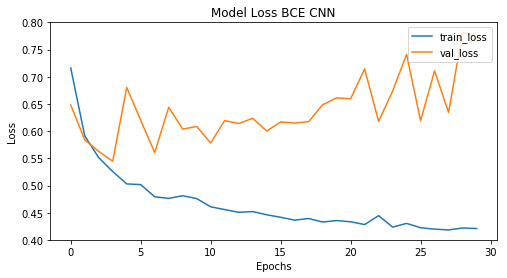

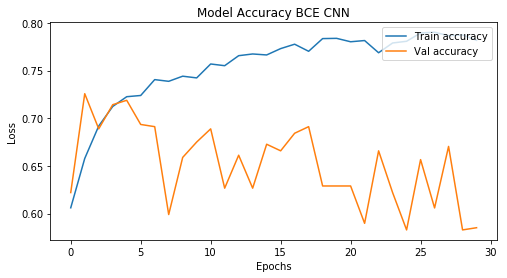

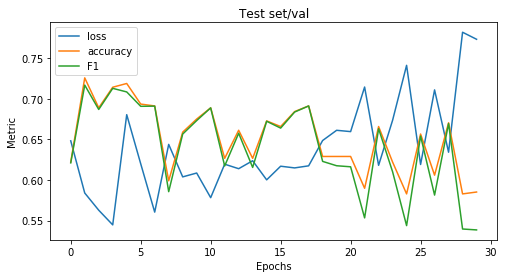

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.631888  0.703337  0.794064     0.680591       0.723615   
Confirmed       0.631888  0.703337  0.469711     0.680591       0.626866   

                Recall raw  
False Positive    0.879711  
Confirmed         0.375559

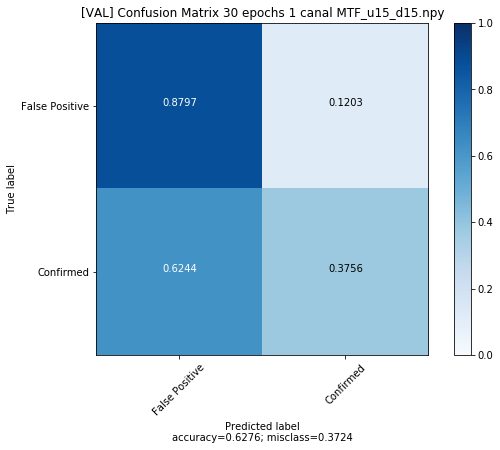

Entrenando usando representación 	Up: 16   Down: 32
 - val_f1: 0.703791 
 - val_f1: 0.709526 
 - val_f1: 0.704950 
 - val_f1: 0.629968 
 - val_f1: 0.634828 
 - val_f1: 0.637230 
 - val_f1: 0.697548 
 - val_f1: 0.425494 
 - val_f1: 0.681489 
 - val_f1: 0.518295 
 - val_f1: 0.685249 
 - val_f1: 0.402562 
 - val_f1: 0.572783 
 - val_f1: 0.603049 
 - val_f1: 0.448481 
 - val_f1: 0.548857 
 - val_f1: 0.425494 
 - val_f1: 0.557697 
 - val_f1: 0.672470 
 - val_f1: 0.423863 
 - val_f1: 0.494661 
 - val_f1: 0.444931 
 - val_f1: 0.561424 
 - val_f1: 0.629968 
 - val_f1: 0.438397 
 - val_f1: 0.666610 
 - val_f1: 0.496694 
 - val_f1: 0.380241 
 - val_f1: 0.459499 
 - val_f1: 0.665066 


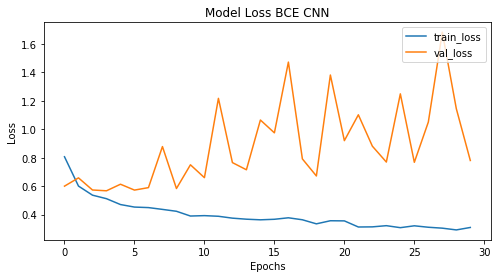

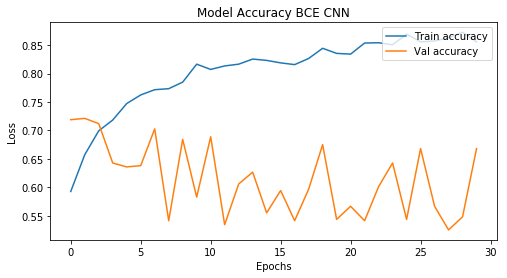

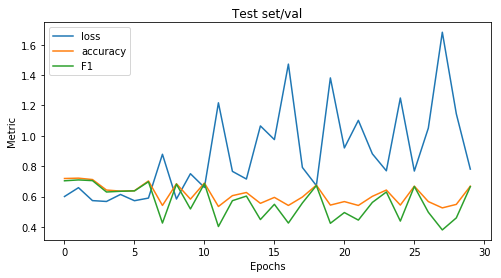

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.650798  0.668926  0.730361     0.674692       0.776173   
Confirmed       0.650798  0.668926  0.571236     0.674692       0.522222   

                Recall raw  
False Positive    0.689655  
Confirmed         0.630402

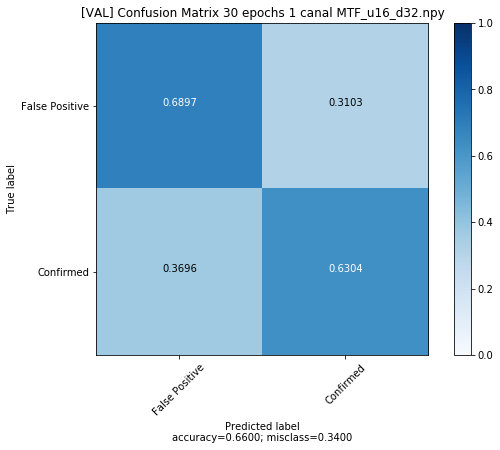

Entrenando usando representación 	Up: 32   Down: 32
 - val_f1: 0.542720 
 - val_f1: 0.684115 
 - val_f1: 0.699326 
 - val_f1: 0.647314 
 - val_f1: 0.660913 
 - val_f1: 0.644406 
 - val_f1: 0.556547 
 - val_f1: 0.564709 
 - val_f1: 0.630342 
 - val_f1: 0.626657 
 - val_f1: 0.438416 
 - val_f1: 0.625967 
 - val_f1: 0.686067 
 - val_f1: 0.559560 
 - val_f1: 0.497004 
 - val_f1: 0.673658 
 - val_f1: 0.640431 
 - val_f1: 0.520268 
 - val_f1: 0.608457 
 - val_f1: 0.518500 
 - val_f1: 0.523223 
 - val_f1: 0.656271 
 - val_f1: 0.457210 
 - val_f1: 0.585394 
 - val_f1: 0.621469 
 - val_f1: 0.605918 
 - val_f1: 0.507975 
 - val_f1: 0.585398 
 - val_f1: 0.552642 
 - val_f1: 0.431282 


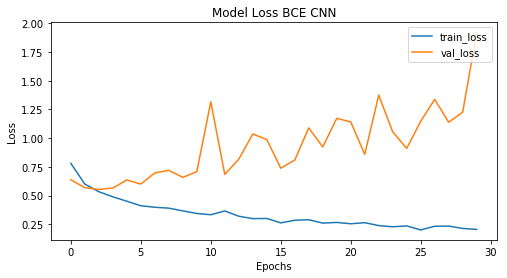

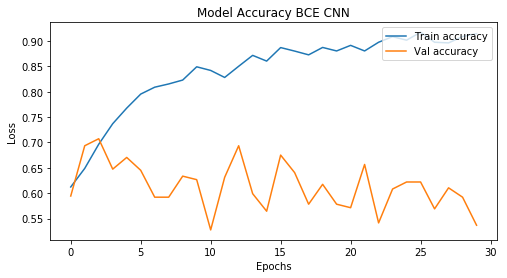

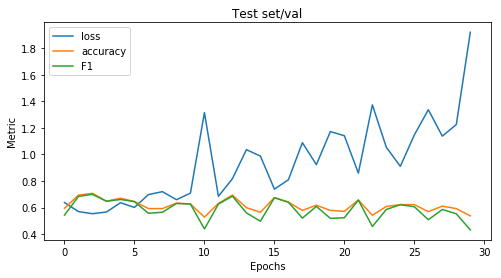

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.518904  0.672576  0.790806      0.60056       0.676353   
Confirmed       0.518904  0.672576  0.247002      0.60056       0.631902   

                Recall raw  
False Positive    0.951885  
Confirmed         0.153502

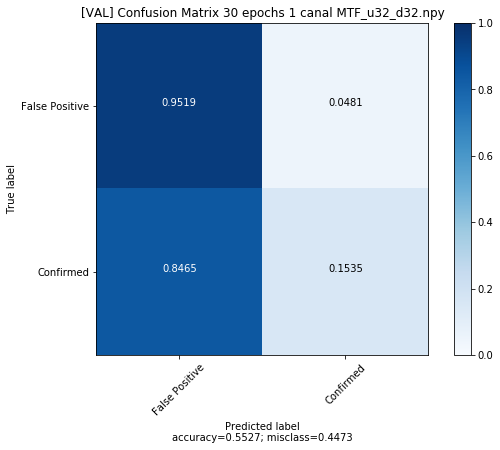

Entrenando usando representación 	Up: 10   Down: 10
 - val_f1: 0.676733 
 - val_f1: 0.662383 
 - val_f1: 0.694591 
 - val_f1: 0.589495 
 - val_f1: 0.650513 
 - val_f1: 0.679912 
 - val_f1: 0.703116 
 - val_f1: 0.658522 
 - val_f1: 0.636820 
 - val_f1: 0.653133 
 - val_f1: 0.683951 
 - val_f1: 0.665257 
 - val_f1: 0.637273 
 - val_f1: 0.677083 
 - val_f1: 0.694624 
 - val_f1: 0.642970 
 - val_f1: 0.648293 
 - val_f1: 0.579543 
 - val_f1: 0.604058 
 - val_f1: 0.656624 
 - val_f1: 0.665684 
 - val_f1: 0.633956 
 - val_f1: 0.614757 
 - val_f1: 0.647607 
 - val_f1: 0.679436 
 - val_f1: 0.596566 
 - val_f1: 0.661202 
 - val_f1: 0.594296 
 - val_f1: 0.600657 
 - val_f1: 0.585878 


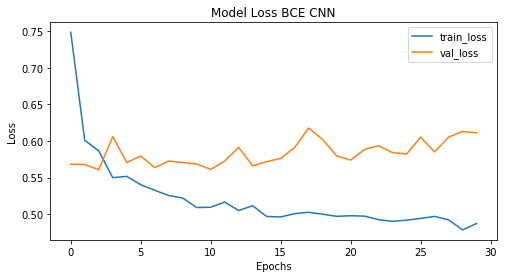

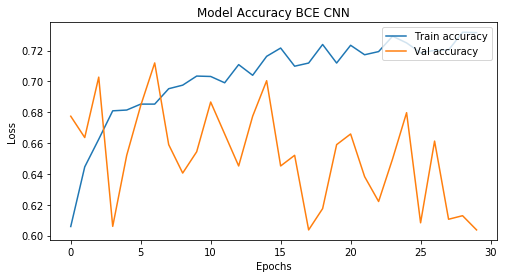

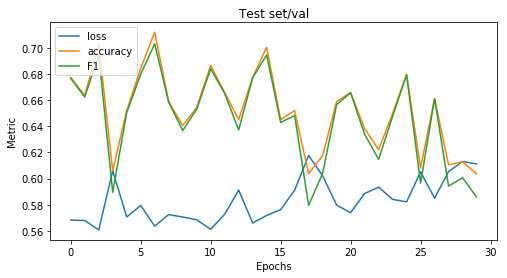

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.665447  0.705422  0.781093     0.700177       0.755622   
Confirmed       0.665447  0.705422  0.549801     0.700177       0.590753   

                Recall raw  
False Positive    0.808340  
Confirmed         0.514158

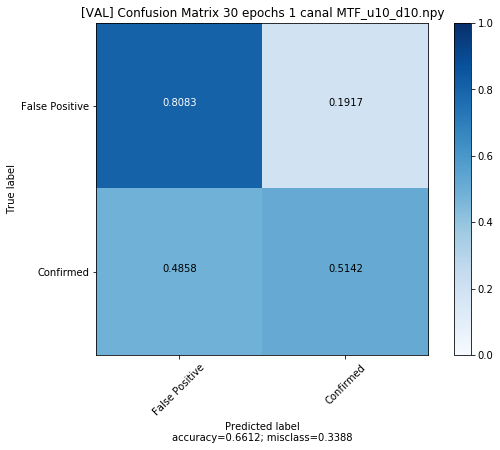

In [20]:
for data in os.listdir('../../../Data_PIIC/Datapi/no_inv/'):
    name= data.split('_')
    print ("Entrenando usando representación \tUp:", name[1][1:], '  Down:', name[2][1:].split('.')[0])
    channel_1 = np.load('../../../Data_PIIC/Datapi/no_inv/'+str(data)) 
    channel_2 = np.load('../../../Data_PIIC/Datapi/inv/'+str(data)) 
    x_all = np.asarray([np.dstack((channel_1[i],channel_2[i])) for i in range(channel_1.shape[0])])   
    x_train = x_all[mask_train]
    x_val = x_all[mask_test]
    if x_train.shape[0] < y_train.shape[0]:
        print ("\n\nVerificar dimensiones de objetos en",data)
        break

    model = Sequential()
    model.add(Flatten(input_shape=x_train.shape[1:]))
    model.add(Dense(256, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    train_model(model, x_train, y_train, x_val, y_val, e=30, BS=64, verbose=False)
    
    predichos=model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,title='[VAL] Confusion Matrix 30 epochs 1 canal '+str(data)) 

#### Focal loss

Entrenando usando representación 	Up: 15   Down: 15
 - val_f1: 0.665450 
 - val_f1: 0.646693 
 - val_f1: 0.691311 
 - val_f1: 0.646421 
 - val_f1: 0.682212 
 - val_f1: 0.641717 
 - val_f1: 0.654917 
 - val_f1: 0.691983 
 - val_f1: 0.662924 
 - val_f1: 0.670113 
 - val_f1: 0.677248 
 - val_f1: 0.687345 
 - val_f1: 0.694111 
 - val_f1: 0.603899 
 - val_f1: 0.630952 
 - val_f1: 0.671968 
 - val_f1: 0.624242 
 - val_f1: 0.597254 
 - val_f1: 0.641278 
 - val_f1: 0.641026 
 - val_f1: 0.668591 
 - val_f1: 0.670365 
 - val_f1: 0.621556 
 - val_f1: 0.627591 
 - val_f1: 0.669410 
 - val_f1: 0.684048 
 - val_f1: 0.664094 
 - val_f1: 0.555835 
 - val_f1: 0.660163 
 - val_f1: 0.649763 


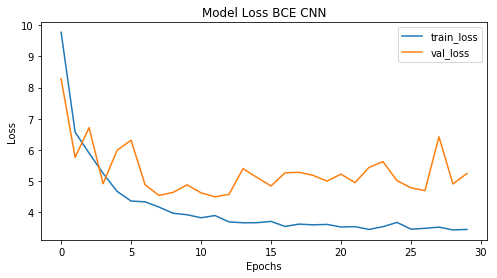

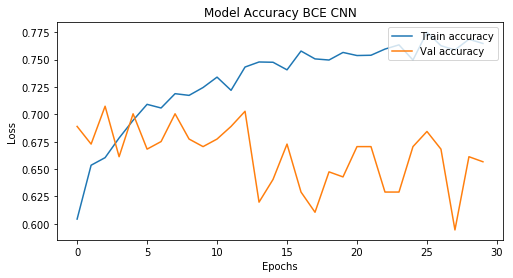

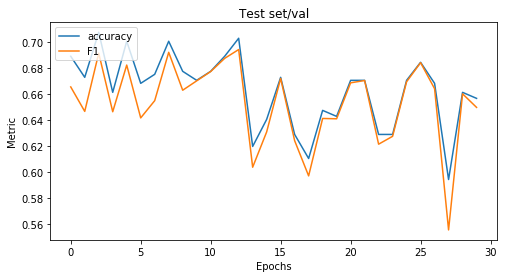

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.672953  0.694473  0.756846     0.698148       0.784179   
Confirmed       0.672953  0.694473  0.589060     0.698148       0.556291   

                Recall raw  
False Positive    0.731355  
Confirmed         0.625931

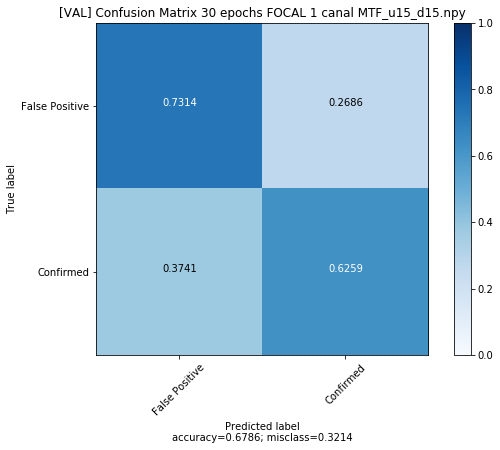

Entrenando usando representación 	Up: 16   Down: 32
 - val_f1: 0.644738 
 - val_f1: 0.698853 
 - val_f1: 0.669601 
 - val_f1: 0.692579 
 - val_f1: 0.706933 
 - val_f1: 0.687345 
 - val_f1: 0.662460 
 - val_f1: 0.682286 
 - val_f1: 0.681595 
 - val_f1: 0.694876 
 - val_f1: 0.714755 
 - val_f1: 0.568977 
 - val_f1: 0.688806 
 - val_f1: 0.434189 
 - val_f1: 0.690789 
 - val_f1: 0.507975 
 - val_f1: 0.648775 
 - val_f1: 0.625234 
 - val_f1: 0.629947 
 - val_f1: 0.693587 
 - val_f1: 0.666154 
 - val_f1: 0.547588 
 - val_f1: 0.616385 
 - val_f1: 0.626906 
 - val_f1: 0.672561 
 - val_f1: 0.578943 
 - val_f1: 0.670505 
 - val_f1: 0.639283 
 - val_f1: 0.657271 
 - val_f1: 0.628929 


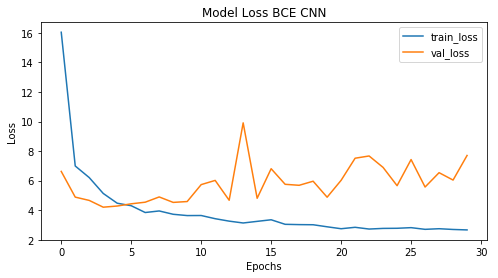

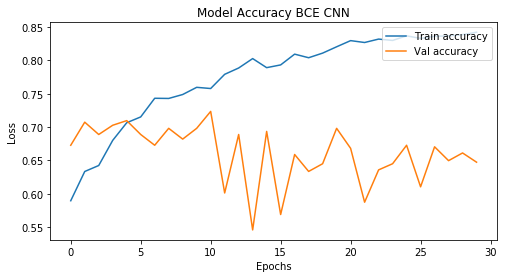

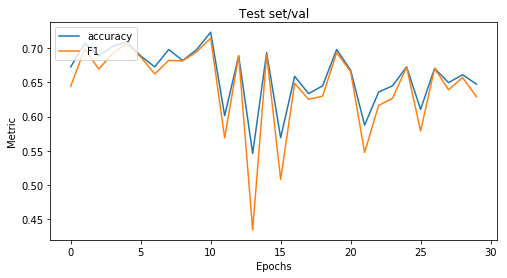

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.635982  0.677789  0.759346      0.67303       0.738077   
Confirmed       0.635982  0.677789  0.512618      0.67303       0.544389   

                Recall raw  
False Positive    0.781877  
Confirmed         0.484352

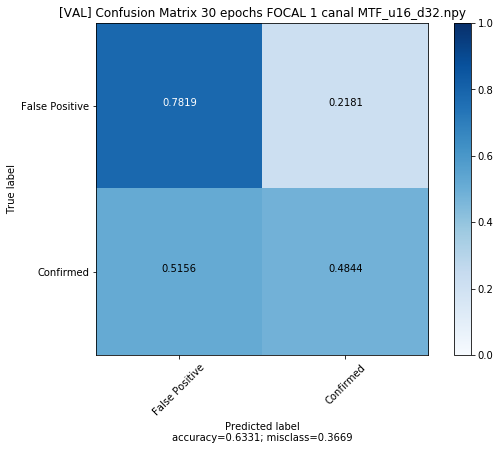

Entrenando usando representación 	Up: 32   Down: 32
 - val_f1: 0.635676 
 - val_f1: 0.612864 
 - val_f1: 0.650716 
 - val_f1: 0.625373 
 - val_f1: 0.690512 
 - val_f1: 0.598212 
 - val_f1: 0.631545 
 - val_f1: 0.643721 
 - val_f1: 0.617440 
 - val_f1: 0.664200 
 - val_f1: 0.662169 
 - val_f1: 0.612027 
 - val_f1: 0.689592 
 - val_f1: 0.555911 
 - val_f1: 0.653887 
 - val_f1: 0.647064 
 - val_f1: 0.664958 
 - val_f1: 0.656534 
 - val_f1: 0.567786 
 - val_f1: 0.569627 
 - val_f1: 0.632217 
 - val_f1: 0.436382 
 - val_f1: 0.614096 
 - val_f1: 0.649762 
 - val_f1: 0.493644 
 - val_f1: 0.590274 
 - val_f1: 0.522015 
 - val_f1: 0.639051 
 - val_f1: 0.507975 
 - val_f1: 0.667825 


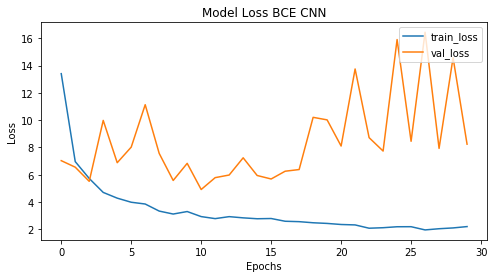

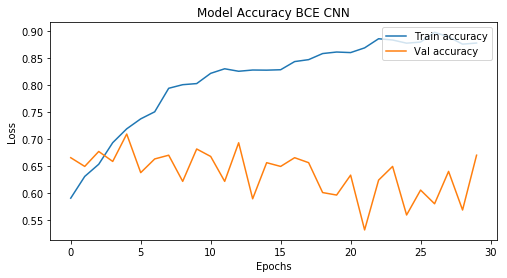

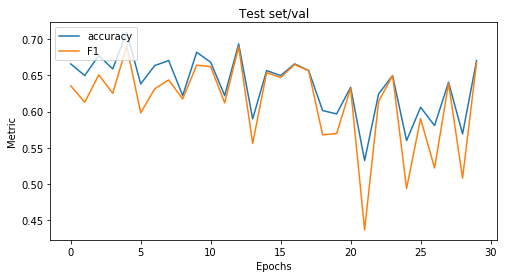

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.648599  0.651199  0.678829     0.657677       0.845694   
Confirmed       0.648599  0.651199  0.618369     0.657677       0.500924   

                Recall raw  
False Positive    0.566961  
Confirmed         0.807750

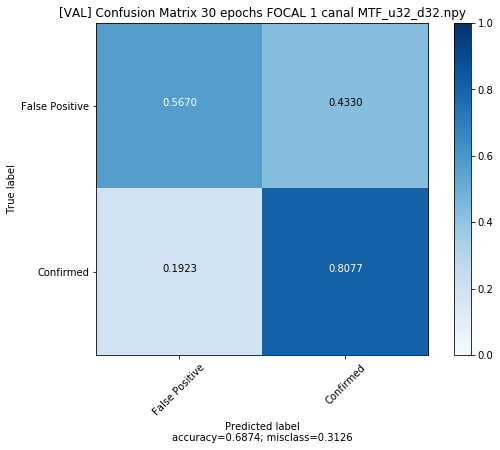

Entrenando usando representación 	Up: 10   Down: 10
 - val_f1: 0.671807 
 - val_f1: 0.645158 
 - val_f1: 0.654404 
 - val_f1: 0.641717 
 - val_f1: 0.695122 
 - val_f1: 0.686450 
 - val_f1: 0.662890 
 - val_f1: 0.649183 
 - val_f1: 0.700493 
 - val_f1: 0.674496 
 - val_f1: 0.651539 
 - val_f1: 0.673693 
 - val_f1: 0.712137 
 - val_f1: 0.670544 
 - val_f1: 0.631510 
 - val_f1: 0.683076 
 - val_f1: 0.665883 
 - val_f1: 0.688546 
 - val_f1: 0.693615 
 - val_f1: 0.695508 
 - val_f1: 0.698087 
 - val_f1: 0.690322 
 - val_f1: 0.661245 
 - val_f1: 0.656534 
 - val_f1: 0.685326 
 - val_f1: 0.698925 
 - val_f1: 0.658979 
 - val_f1: 0.687131 
 - val_f1: 0.678081 
 - val_f1: 0.658921 


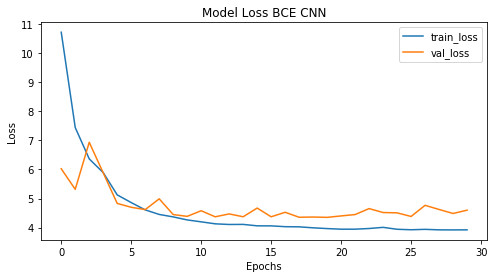

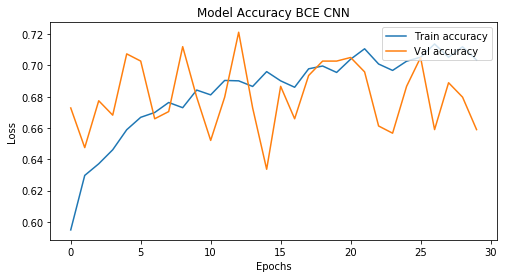

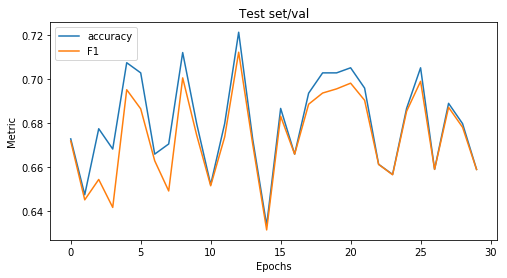

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive   0.66127  0.669447  0.713899     0.677075       0.816305   
Confirmed        0.66127  0.669447  0.608642     0.677075       0.519494   

                Recall raw  
False Positive    0.634322  
Confirmed         0.734724

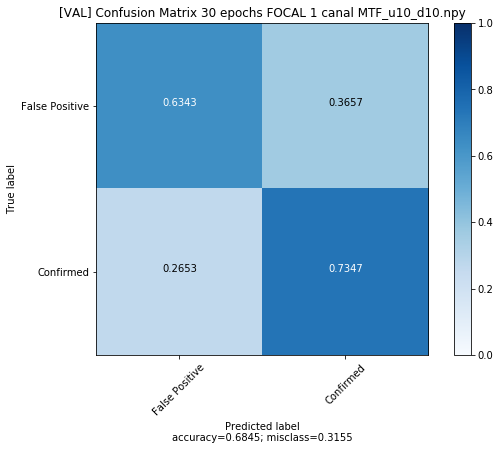

In [21]:
for data in os.listdir('../../../Data_PIIC/Datapi/no_inv/'):
    name= data.split('_')
    print ("Entrenando usando representación \tUp:", name[1][1:], '  Down:', name[2][1:].split('.')[0])
    channel_1 = np.load('../../../Data_PIIC/Datapi/no_inv/'+str(data)) 
    channel_2 = np.load('../../../Data_PIIC/Datapi/inv/'+str(data)) 
    x_all = np.asarray([np.dstack((channel_1[i],channel_2[i])) for i in range(channel_1.shape[0])])   
    x_train = x_all[mask_train]
    x_val = x_all[mask_test]
    if x_train.shape[0] < y_train.shape[0]:
        print ("\n\nVerificar dimensiones de objetos en",data)
        break

    model = Sequential()
    model.add(Flatten(input_shape=x_train.shape[1:]))
    model.add(Dense(256, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    train_model(model, x_train, y_train, x_val, y_val, e=30, BS=64, focal=True, verbose=False)
    
    predichos=model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,title='[VAL] Confusion Matrix 30 epochs FOCAL 1 canal '+str(data)) 

## Modelo 2

### BCE

Entrenando usando representación 	Up: 15   Down: 15
 - val_f1: 0.567707 
 - val_f1: 0.344656 
 - val_f1: 0.357139 
 - val_f1: 0.412224 
 - val_f1: 0.399548 
 - val_f1: 0.420308 
 - val_f1: 0.420308 
 - val_f1: 0.618952 
 - val_f1: 0.523762 
 - val_f1: 0.573483 
 - val_f1: 0.495138 
 - val_f1: 0.539593 
 - val_f1: 0.544520 
 - val_f1: 0.479661 
 - val_f1: 0.495838 
 - val_f1: 0.461411 
 - val_f1: 0.455836 
 - val_f1: 0.571281 
 - val_f1: 0.525510 
 - val_f1: 0.532511 
 - val_f1: 0.509782 
 - val_f1: 0.583344 
 - val_f1: 0.464411 
 - val_f1: 0.509137 
 - val_f1: 0.691008 
 - val_f1: 0.616269 
 - val_f1: 0.580400 
 - val_f1: 0.567502 
 - val_f1: 0.639283 
 - val_f1: 0.533583 


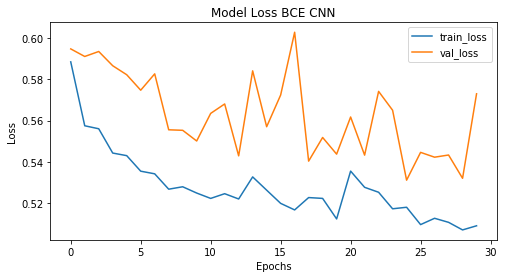

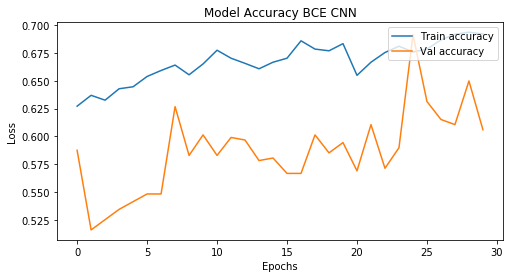

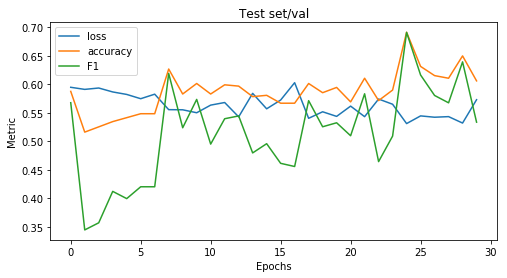

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.548853   0.68926  0.800535     0.624436       0.686962   
Confirmed       0.548853   0.68926  0.297170     0.624436       0.711864   

                Recall raw  
False Positive    0.959102  
Confirmed         0.187779

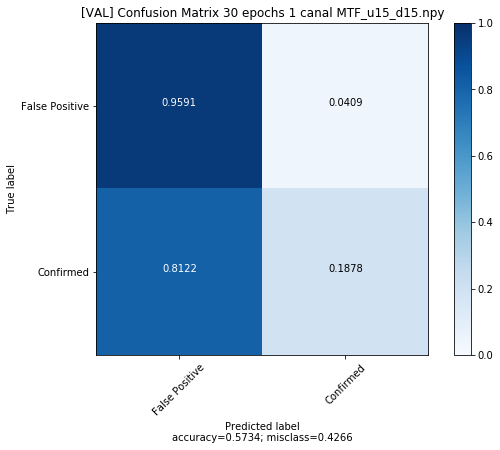

Entrenando usando representación 	Up: 16   Down: 32
 - val_f1: 0.642703 
 - val_f1: 0.451517 
 - val_f1: 0.386258 
 - val_f1: 0.642914 
 - val_f1: 0.453531 
 - val_f1: 0.599588 
 - val_f1: 0.428002 
 - val_f1: 0.448583 
 - val_f1: 0.665257 
 - val_f1: 0.614060 
 - val_f1: 0.518425 
 - val_f1: 0.586389 
 - val_f1: 0.528583 
 - val_f1: 0.469814 
 - val_f1: 0.457308 
 - val_f1: 0.508781 
 - val_f1: 0.516397 
 - val_f1: 0.512152 
 - val_f1: 0.515528 
 - val_f1: 0.541240 
 - val_f1: 0.523257 
 - val_f1: 0.493524 
 - val_f1: 0.502345 
 - val_f1: 0.519272 
 - val_f1: 0.577338 
 - val_f1: 0.520971 
 - val_f1: 0.615203 
 - val_f1: 0.507937 
 - val_f1: 0.587357 
 - val_f1: 0.580400 


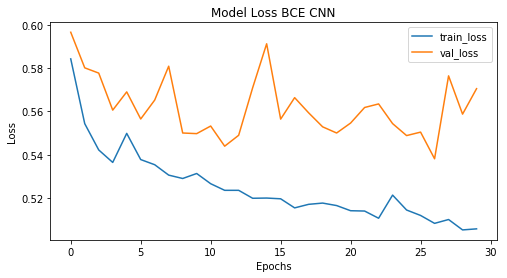

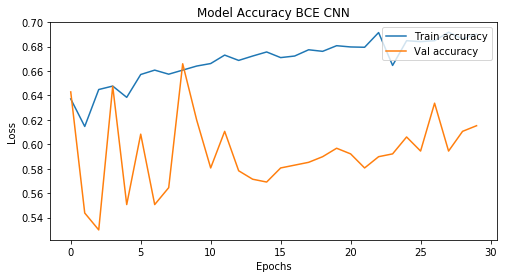

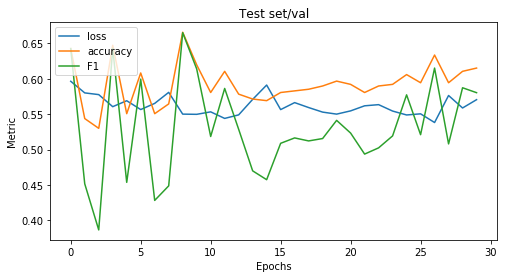

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.651401  0.726799  0.813523     0.700088       0.731286   
Confirmed       0.651401  0.726799  0.489279     0.700088       0.707042   

                Recall raw  
False Positive    0.916600  
Confirmed         0.374069

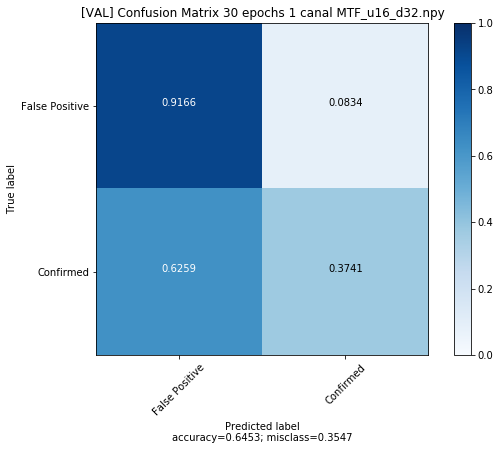

Entrenando usando representación 	Up: 32   Down: 32
 - val_f1: 0.346707 
 - val_f1: 0.350897 
 - val_f1: 0.457951 
 - val_f1: 0.394517 
 - val_f1: 0.682001 
 - val_f1: 0.475252 
 - val_f1: 0.426223 
 - val_f1: 0.454196 
 - val_f1: 0.495138 
 - val_f1: 0.684250 
 - val_f1: 0.652933 
 - val_f1: 0.580215 
 - val_f1: 0.570349 
 - val_f1: 0.526694 
 - val_f1: 0.499742 
 - val_f1: 0.507937 
 - val_f1: 0.452893 
 - val_f1: 0.682021 
 - val_f1: 0.562752 
 - val_f1: 0.514853 
 - val_f1: 0.550685 
 - val_f1: 0.645062 
 - val_f1: 0.538887 
 - val_f1: 0.582300 
 - val_f1: 0.508569 
 - val_f1: 0.600819 
 - val_f1: 0.464113 
 - val_f1: 0.716046 
 - val_f1: 0.534982 
 - val_f1: 0.643401 


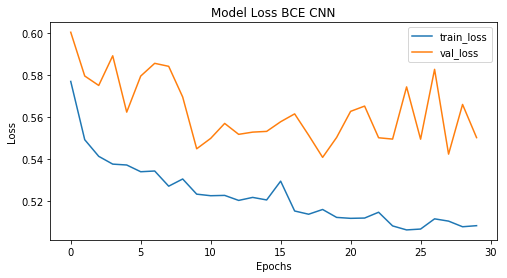

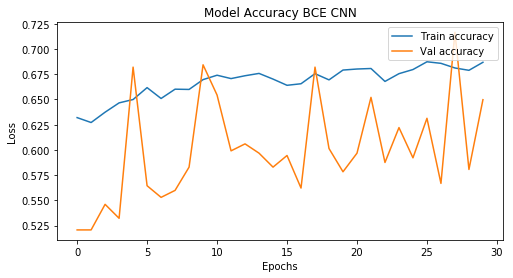

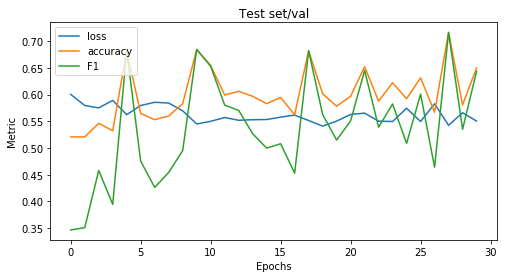

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.688506  0.716893  0.782539     0.716746       0.781600   
Confirmed       0.688506  0.716893  0.594473     0.716746       0.595808   

                Recall raw  
False Positive    0.783480  
Confirmed         0.593145

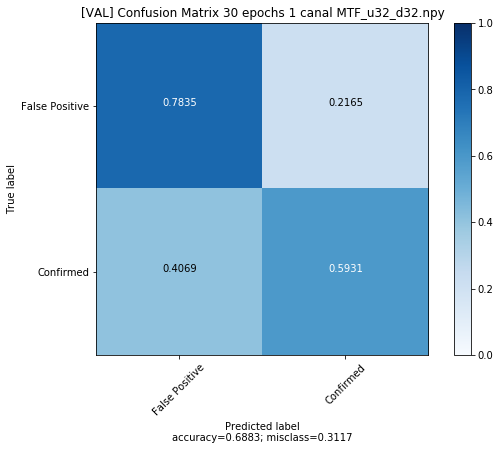

Entrenando usando representación 	Up: 10   Down: 10
 - val_f1: 0.605229 
 - val_f1: 0.473157 


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - val_f1: 0.341426 
 - val_f1: 0.436941 
 - val_f1: 0.341426 
 - val_f1: 0.387479 
 - val_f1: 0.381313 
 - val_f1: 0.542497 
 - val_f1: 0.656352 
 - val_f1: 0.520238 
 - val_f1: 0.619412 
 - val_f1: 0.608700 
 - val_f1: 0.627852 
 - val_f1: 0.585849 
 - val_f1: 0.656548 
 - val_f1: 0.552017 
 - val_f1: 0.593892 
 - val_f1: 0.608670 
 - val_f1: 0.558210 
 - val_f1: 0.651875 
 - val_f1: 0.614377 
 - val_f1: 0.584743 
 - val_f1: 0.571123 
 - val_f1: 0.555591 
 - val_f1: 0.608841 
 - val_f1: 0.531557 
 - val_f1: 0.644669 
 - val_f1: 0.663414 
 - val_f1: 0.587139 
 - val_f1: 0.604709 


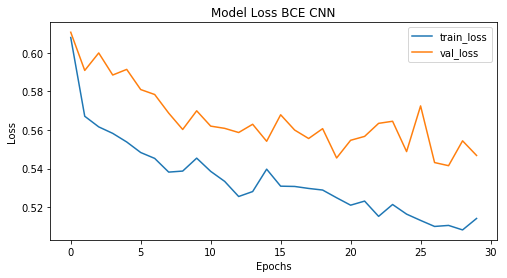

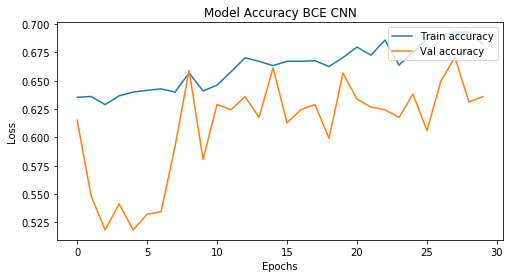

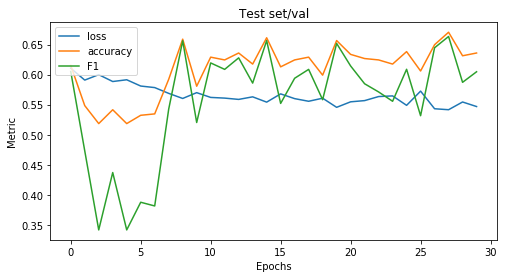

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.640755  0.708029  0.796215     0.687442       0.728847   
Confirmed       0.640755  0.708029  0.485294     0.687442       0.633094   

                Recall raw  
False Positive    0.877306  
Confirmed         0.393443

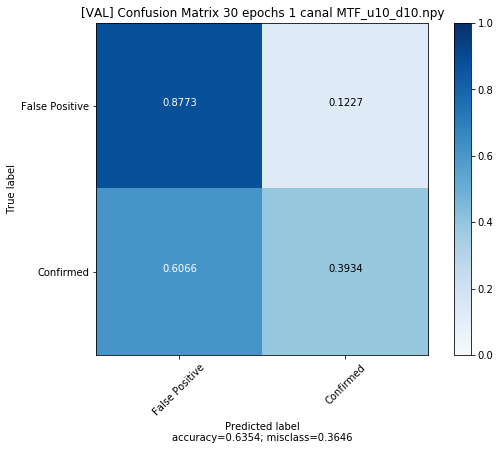

In [23]:
for data in os.listdir('../../../Data_PIIC/Datapi/no_inv/'):
    name= data.split('_')
    u= name[1][1:]
    d= name[2][1:].split('.')[0]
    print ("Entrenando usando representación \tUp:",u , '  Down:', d)
    channel_1 = np.load('../../../Data_PIIC/Datapi/no_inv/'+str(data)) 
    channel_2 = np.load('../../../Data_PIIC/Datapi/inv/'+str(data)) 
    x_all = np.asarray([np.dstack((channel_1[i],channel_2[i])) for i in range(channel_1.shape[0])])   
    x_train = x_all[mask_train]
    x_val = x_all[mask_test]
    if x_train.shape[0] < y_train.shape[0]:
        print ("\n\nVerificar dimensiones de objetos en",data)
        break

    a=int(u)+int(d)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(a,a,2), strides=(1, 1),activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    train_model(model, x_train, y_train, x_val, y_val, e=30, BS=64, verbose=False)
    
    predichos=model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,title='[VAL] Confusion Matrix 30 epochs 1 canal '+str(data)) 
    

#### Focal loss

Entrenando usando representación 	Up: 15   Down: 15
 - val_f1: 0.669413 
 - val_f1: 0.696018 
 - val_f1: 0.695388 
 - val_f1: 0.700984 
 - val_f1: 0.700493 
 - val_f1: 0.700843 
 - val_f1: 0.712202 
 - val_f1: 0.679179 
 - val_f1: 0.683083 
 - val_f1: 0.691659 
 - val_f1: 0.698737 
 - val_f1: 0.698935 
 - val_f1: 0.693802 
 - val_f1: 0.708377 
 - val_f1: 0.704236 
 - val_f1: 0.698930 
 - val_f1: 0.708487 
 - val_f1: 0.704724 
 - val_f1: 0.702621 
 - val_f1: 0.702950 
 - val_f1: 0.709526 
 - val_f1: 0.708338 
 - val_f1: 0.711647 
 - val_f1: 0.706841 
 - val_f1: 0.703224 
 - val_f1: 0.714869 
 - val_f1: 0.708377 
 - val_f1: 0.715397 
 - val_f1: 0.710077 
 - val_f1: 0.712202 


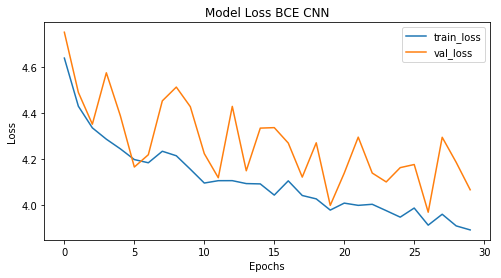

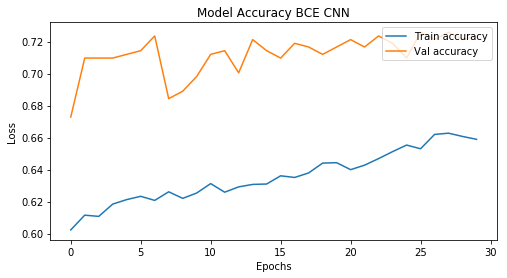

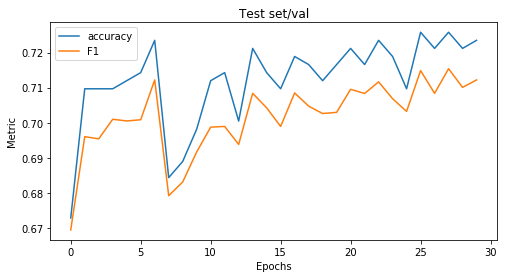

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.657415  0.657456  0.653664     0.656288       0.953846   
Confirmed       0.657415  0.657456  0.661166     0.656288       0.505521   

                Recall raw  
False Positive    0.497193  
Confirmed         0.955291

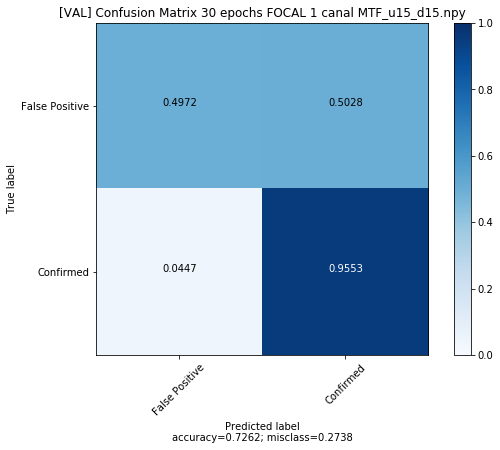

Entrenando usando representación 	Up: 16   Down: 32
 - val_f1: 0.695225 
 - val_f1: 0.694527 
 - val_f1: 0.706841 
 - val_f1: 0.698120 
 - val_f1: 0.706841 
 - val_f1: 0.697487 
 - val_f1: 0.707949 
 - val_f1: 0.685630 
 - val_f1: 0.699338 
 - val_f1: 0.710614 
 - val_f1: 0.729462 
 - val_f1: 0.705668 
 - val_f1: 0.714327 
 - val_f1: 0.710077 
 - val_f1: 0.719157 
 - val_f1: 0.709526 
 - val_f1: 0.711647 
 - val_f1: 0.725942 
 - val_f1: 0.712202 
 - val_f1: 0.691991 
 - val_f1: 0.706262 
 - val_f1: 0.721653 
 - val_f1: 0.707405 
 - val_f1: 0.710077 
 - val_f1: 0.727308 
 - val_f1: 0.692528 
 - val_f1: 0.715579 
 - val_f1: 0.728554 
 - val_f1: 0.710077 
 - val_f1: 0.711647 


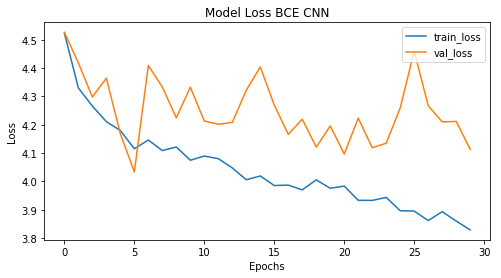

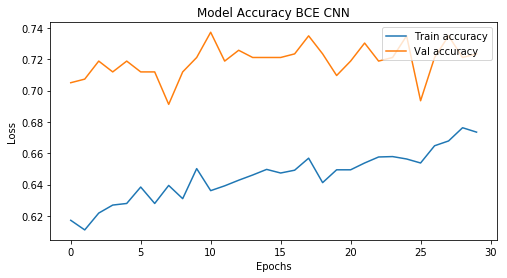

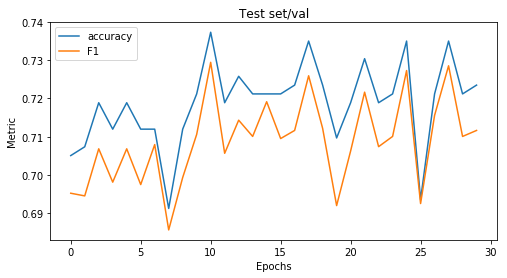

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.658465  0.658498  0.655082     0.657449       0.953988   
Confirmed       0.658465  0.658498  0.661848     0.657449       0.506319   

                Recall raw  
False Positive    0.498797  
Confirmed         0.955291

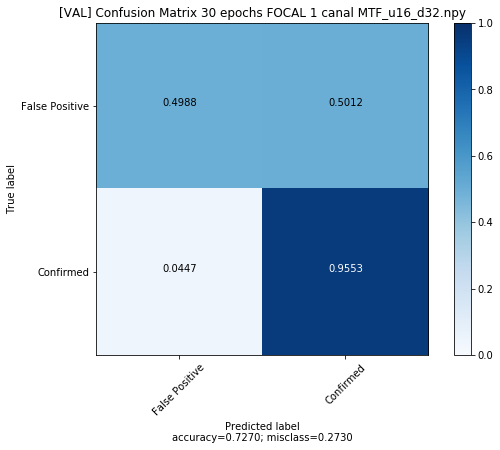

Entrenando usando representación 	Up: 32   Down: 32
 - val_f1: 0.704749 
 - val_f1: 0.707379 
 - val_f1: 0.703116 
 - val_f1: 0.707379 
 - val_f1: 0.686517 
 - val_f1: 0.702371 
 - val_f1: 0.700984 
 - val_f1: 0.713266 
 - val_f1: 0.706841 
 - val_f1: 0.684923 
 - val_f1: 0.696722 
 - val_f1: 0.698120 
 - val_f1: 0.703596 
 - val_f1: 0.700659 
 - val_f1: 0.713266 
 - val_f1: 0.706200 
 - val_f1: 0.716410 
 - val_f1: 0.701923 
 - val_f1: 0.711644 
 - val_f1: 0.710077 
 - val_f1: 0.712202 
 - val_f1: 0.696631 
 - val_f1: 0.715397 
 - val_f1: 0.708487 
 - val_f1: 0.709511 
 - val_f1: 0.709448 
 - val_f1: 0.710614 
 - val_f1: 0.718045 
 - val_f1: 0.703557 
 - val_f1: 0.705285 


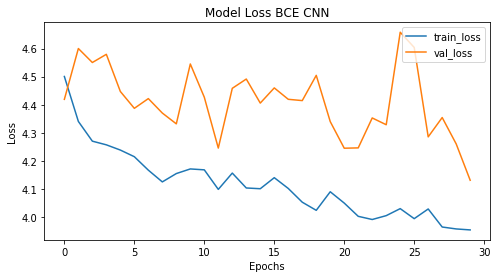

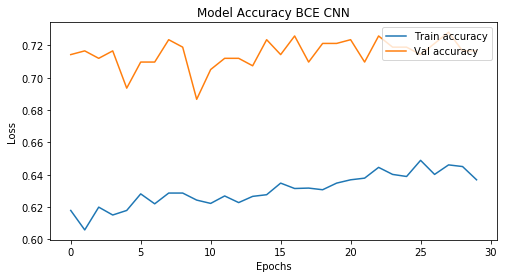

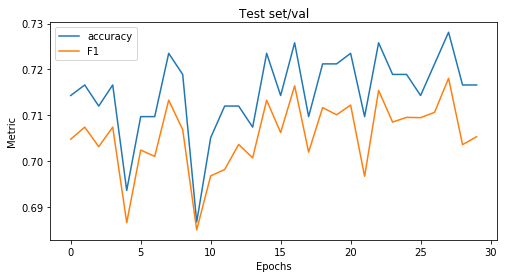

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive   0.65367  0.653806  0.646809     0.651609       0.960506   
Confirmed        0.65367  0.653806  0.660532     0.651609       0.502724   

                Recall raw  
False Positive    0.487570  
Confirmed         0.962742

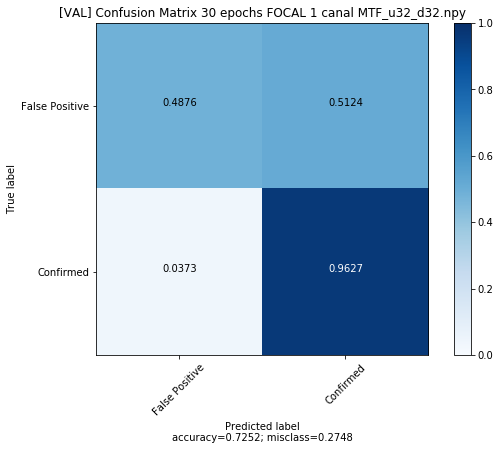

Entrenando usando representación 	Up: 10   Down: 10
 - val_f1: 0.677537 
 - val_f1: 0.674636 
 - val_f1: 0.674655 
 - val_f1: 0.691192 
 - val_f1: 0.681588 
 - val_f1: 0.681588 
 - val_f1: 0.675258 
 - val_f1: 0.688460 
 - val_f1: 0.693916 
 - val_f1: 0.698737 
 - val_f1: 0.704236 
 - val_f1: 0.697345 
 - val_f1: 0.708959 
 - val_f1: 0.691311 
 - val_f1: 0.673716 
 - val_f1: 0.702950 
 - val_f1: 0.700223 
 - val_f1: 0.712202 
 - val_f1: 0.698120 
 - val_f1: 0.705668 
 - val_f1: 0.702035 
 - val_f1: 0.697487 
 - val_f1: 0.717742 
 - val_f1: 0.708377 
 - val_f1: 0.704148 
 - val_f1: 0.708377 
 - val_f1: 0.726866 
 - val_f1: 0.694742 
 - val_f1: 0.713266 
 - val_f1: 0.712741 


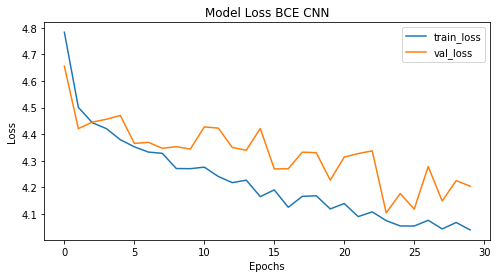

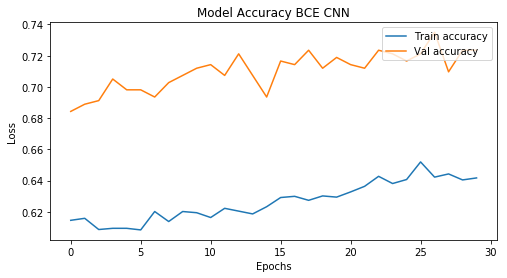

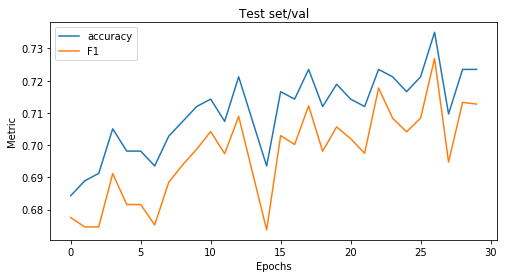

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.644824  0.644943  0.638343     0.642878       0.944969   
Confirmed       0.644824  0.644943  0.651306     0.642878       0.496100   

                Recall raw  
False Positive    0.481957  
Confirmed         0.947839

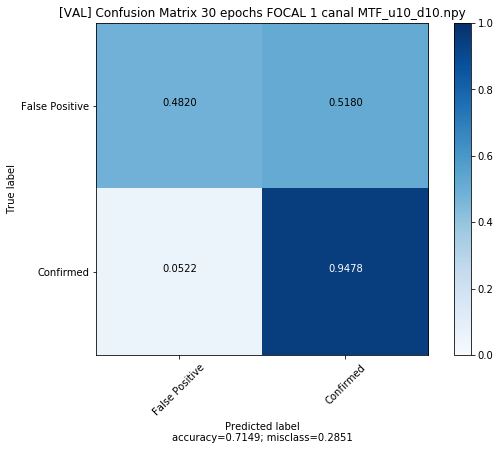

In [25]:
for data in os.listdir('../../../Data_PIIC/Datapi/no_inv/'):
    name= data.split('_')
    u= name[1][1:]
    d= name[2][1:].split('.')[0]
    print ("Entrenando usando representación \tUp:",u , '  Down:', d)
    channel_1 = np.load('../../../Data_PIIC/Datapi/no_inv/'+str(data)) 
    channel_2 = np.load('../../../Data_PIIC/Datapi/inv/'+str(data)) 
    x_all = np.asarray([np.dstack((channel_1[i],channel_2[i])) for i in range(channel_1.shape[0])])   
    x_train = x_all[mask_train]
    x_val = x_all[mask_test]
    if x_train.shape[0] < y_train.shape[0]:
        print ("\n\nVerificar dimensiones de objetos en",data)
        break

    a=int(u)+int(d)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(a,a,2), strides=(1, 1),activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    train_model(model, x_train, y_train, x_val, y_val, e=30, BS=64, focal=True, verbose=False)
    
    predichos=model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,title='[VAL] Confusion Matrix 30 epochs FOCAL 1 canal '+str(data)) 
    

## Modelo 3

### BCE

Entrenando usando representación 	Up: 15   Down: 15


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.361199 
 - val_f1: 0.698513 
 - val_f1: 0.449424 
 - val_f1: 0.366288 
 - val_f1: 0.570349 
 - val_f1: 0.444175 
 - val_f1: 0.487160 
 - val_f1: 0.413063 
 - val_f1: 0.401759 
 - val_f1: 0.674616 
 - val_f1: 0.711023 
 - val_f1: 0.499188 
 - val_f1: 0.598136 
 - val_f1: 0.556969 
 - val_f1: 0.586083 
 - val_f1: 0.493529 
 - val_f1: 0.509579 
 - val_f1: 0.635455 
 - val_f1: 0.592770 
 - val_f1: 0.562683 
 - val_f1: 0.555336 
 - val_f1: 0.574490 
 - val_f1: 0.637771 
 - val_f1: 0.610798 
 - val_f1: 0.702281 
 - val_f1: 0.675427 


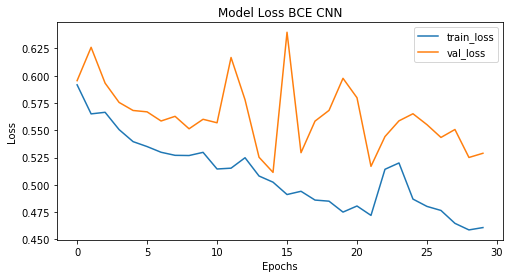

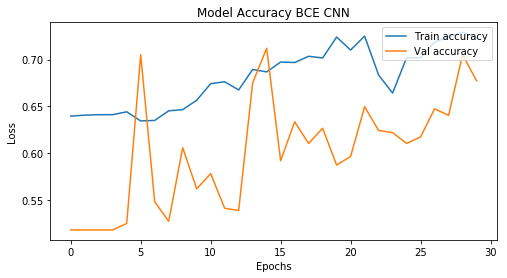

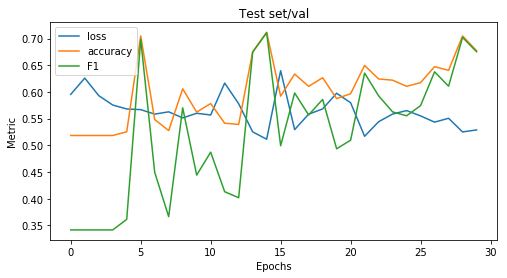

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.701903  0.719499  0.774329     0.723653       0.811785   
Confirmed       0.701903  0.719499  0.629477     0.723653       0.585147   

                Recall raw  
False Positive    0.740176  
Confirmed         0.681073

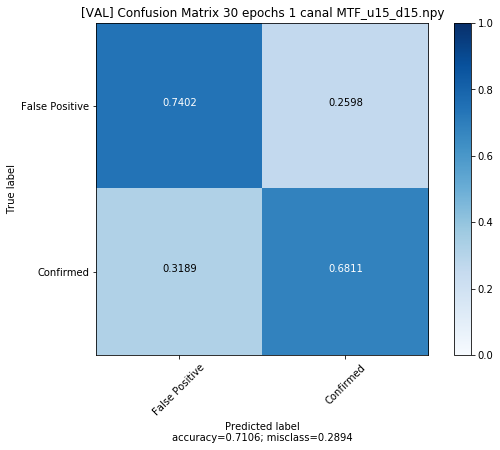

Entrenando usando representación 	Up: 16   Down: 32
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.346707 
 - val_f1: 0.366288 
 - val_f1: 0.548477 
 - val_f1: 0.365173 
 - val_f1: 0.589321 
 - val_f1: 0.482247 
 - val_f1: 0.693417 
 - val_f1: 0.617689 
 - val_f1: 0.369061 
 - val_f1: 0.450047 
 - val_f1: 0.664433 
 - val_f1: 0.548121 
 - val_f1: 0.438469 
 - val_f1: 0.490343 
 - val_f1: 0.624079 
 - val_f1: 0.451422 
 - val_f1: 0.351944 
 - val_f1: 0.553345 
 - val_f1: 0.613824 
 - val_f1: 0.607459 
 - val_f1: 0.556969 
 - val_f1: 0.515528 
 - val_f1: 0.664724 
 - val_f1: 0.565016 
 - val_f1: 0.631863 
 - val_f1: 0.640828 


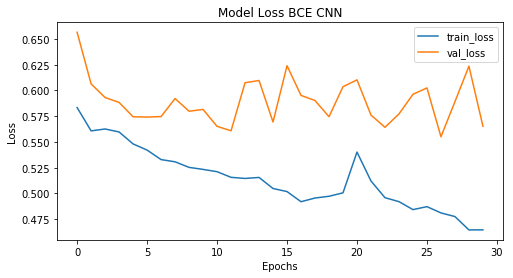

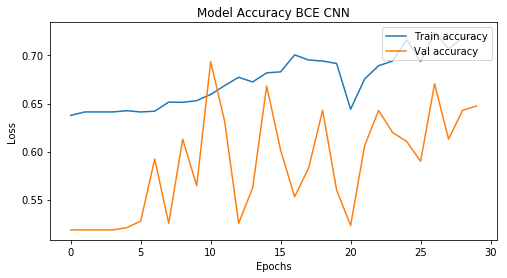

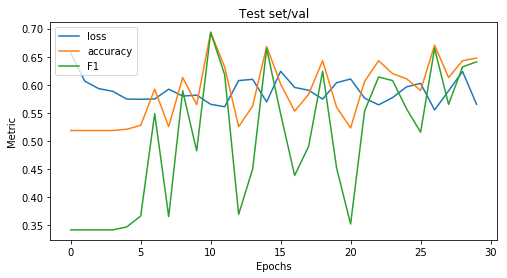

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.694353  0.721064  0.784708     0.721488       0.787561   
Confirmed       0.694353  0.721064  0.603997     0.721488       0.600000   

                Recall raw  
False Positive    0.781877  
Confirmed         0.608048

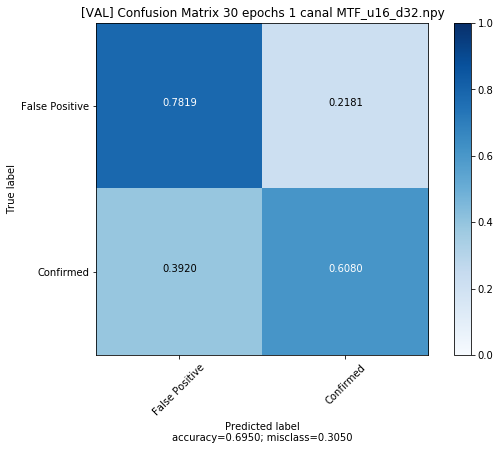

Entrenando usando representación 	Up: 32   Down: 32
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.446944 
 - val_f1: 0.427032 
 - val_f1: 0.522968 
 - val_f1: 0.432301 
 - val_f1: 0.364055 
 - val_f1: 0.398292 
 - val_f1: 0.360105 
 - val_f1: 0.688806 
 - val_f1: 0.442599 
 - val_f1: 0.365173 
 - val_f1: 0.522968 
 - val_f1: 0.657561 
 - val_f1: 0.448583 
 - val_f1: 0.494214 
 - val_f1: 0.630462 
 - val_f1: 0.534174 
 - val_f1: 0.500717 
 - val_f1: 0.610666 
 - val_f1: 0.720631 
 - val_f1: 0.657561 
 - val_f1: 0.517217 
 - val_f1: 0.528644 
 - val_f1: 0.444175 
 - val_f1: 0.622058 
 - val_f1: 0.543136 
 - val_f1: 0.483779 


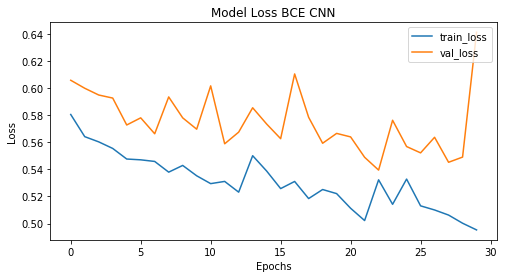

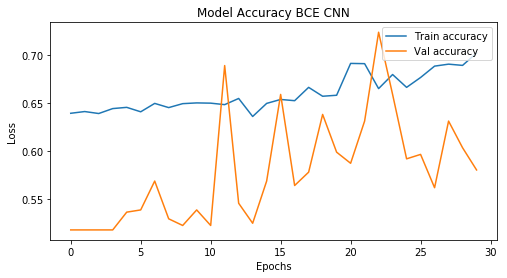

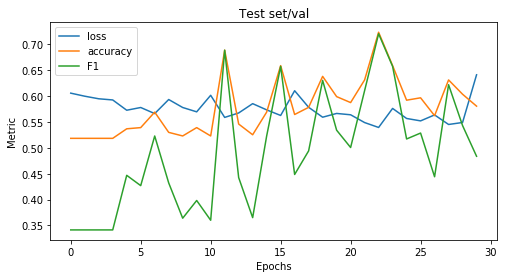

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.518939  0.689781  0.805619     0.605032       0.679713   
Confirmed       0.518939  0.689781  0.232258     0.605032       0.865385   

                Recall raw  
False Positive    0.988773  
Confirmed         0.134128

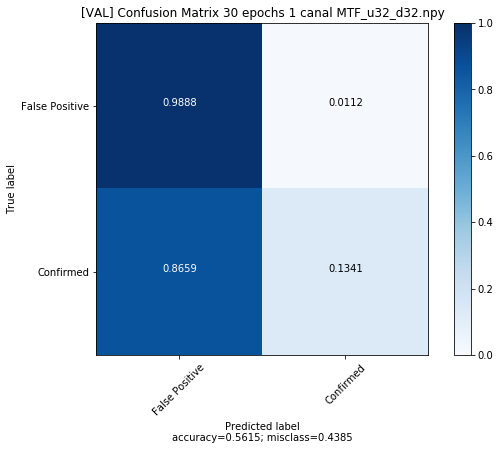

Entrenando usando representación 	Up: 10   Down: 10
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.350897 
 - val_f1: 0.366288 
 - val_f1: 0.485570 
 - val_f1: 0.546643 
 - val_f1: 0.414393 
 - val_f1: 0.527085 
 - val_f1: 0.412413 
 - val_f1: 0.526415 
 - val_f1: 0.426223 
 - val_f1: 0.543025 
 - val_f1: 0.625641 
 - val_f1: 0.613991 
 - val_f1: 0.624079 
 - val_f1: 0.563441 
 - val_f1: 0.668090 
 - val_f1: 0.663551 
 - val_f1: 0.687732 
 - val_f1: 0.465912 
 - val_f1: 0.527381 
 - val_f1: 0.630659 
 - val_f1: 0.583375 
 - val_f1: 0.667008 
 - val_f1: 0.606884 
 - val_f1: 0.612899 
 - val_f1: 0.602435 


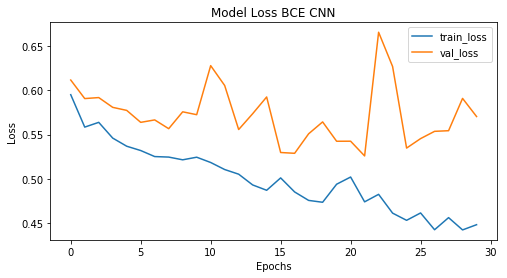

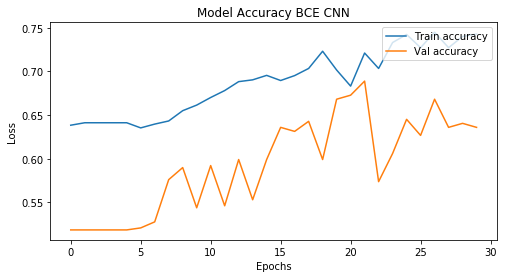

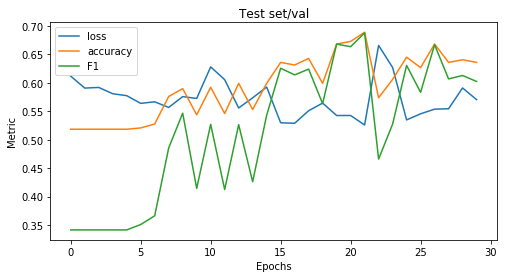

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.645968  0.718978  0.806741      0.69425       0.729572   
Confirmed       0.645968  0.718978  0.485196      0.69425       0.675532   

                Recall raw  
False Positive    0.902165  
Confirmed         0.378539

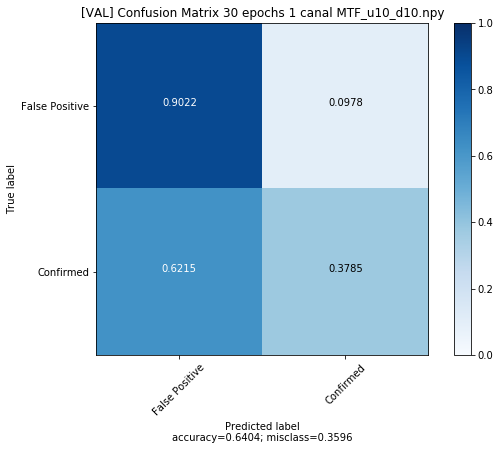

In [10]:
for data in os.listdir('../../../Data_PIIC/Datapi/no_inv/'):
    name= data.split('_')
    u= name[1][1:]
    d= name[2][1:].split('.')[0]
    print ("Entrenando usando representación \tUp:",u , '  Down:', d)
    channel_1 = np.load('../../../Data_PIIC/Datapi/no_inv/'+str(data)) 
    channel_2 = np.load('../../../Data_PIIC/Datapi/inv/'+str(data)) 
    x_all = np.asarray([np.dstack((channel_1[i],channel_2[i])) for i in range(channel_1.shape[0])])   
    x_train = x_all[mask_train]
    x_val = x_all[mask_test]
    if x_train.shape[0] < y_train.shape[0]:
        print ("\n\nVerificar dimensiones de objetos en",data)
        break

    a=int(u)+int(d)
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=(a,a,2), strides=(1, 1),activation="relu", padding="same"))
    model.add(MaxPooling2D((2,2)))
    #model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="same"))
    model.add(MaxPooling2D((2,2)))
    #model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="same"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="same"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    #model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    train_model(model, x_train, y_train, x_val, y_val, e=30, BS=64, verbose=False)
    
    predichos=model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,title='[VAL] Confusion Matrix 30 epochs 1 canal '+str(data)) 

#### Focal Loss

Entrenando usando representación 	Up: 15   Down: 15
 - val_f1: 0.662242 
 - val_f1: 0.680095 
 - val_f1: 0.697229 
 - val_f1: 0.644738 
 - val_f1: 0.693615 
 - val_f1: 0.690553 
 - val_f1: 0.697345 
 - val_f1: 0.690618 
 - val_f1: 0.693105 
 - val_f1: 0.692704 
 - val_f1: 0.715223 
 - val_f1: 0.710001 
 - val_f1: 0.702371 
 - val_f1: 0.667490 
 - val_f1: 0.697812 
 - val_f1: 0.712741 
 - val_f1: 0.670407 
 - val_f1: 0.705058 
 - val_f1: 0.720181 
 - val_f1: 0.714123 
 - val_f1: 0.704432 
 - val_f1: 0.710307 
 - val_f1: 0.718696 
 - val_f1: 0.707435 
 - val_f1: 0.713531 
 - val_f1: 0.705458 
 - val_f1: 0.711964 
 - val_f1: 0.708959 
 - val_f1: 0.699535 
 - val_f1: 0.707379 


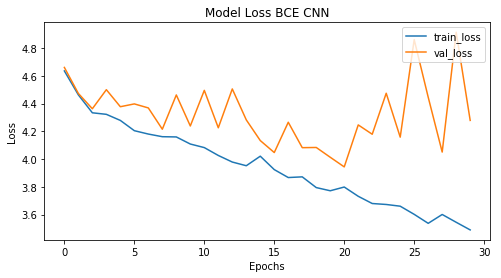

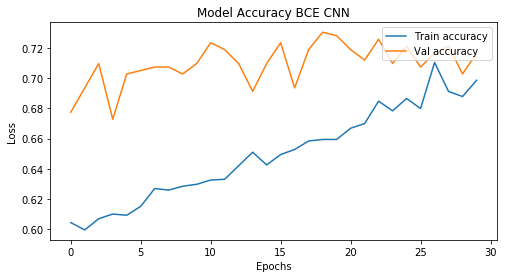

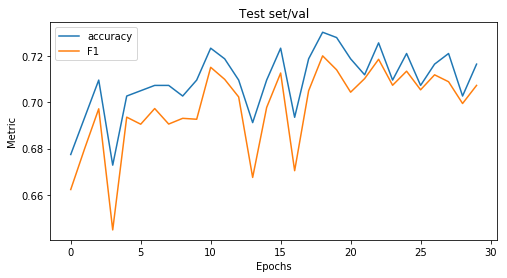

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.667344  0.667362  0.669772     0.668073       0.944526   
Confirmed       0.667344  0.667362  0.664916     0.668073       0.513382   

                Recall raw  
False Positive    0.518845  
Confirmed         0.943368

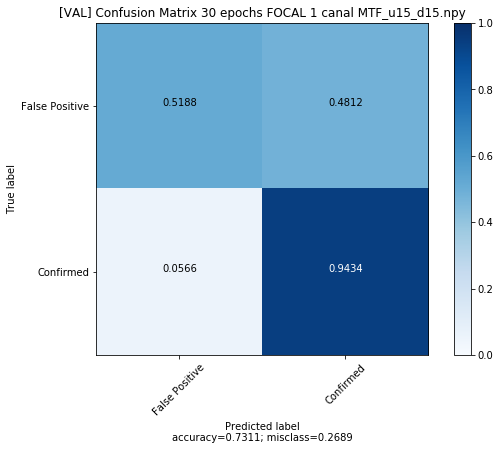

Entrenando usando representación 	Up: 16   Down: 32
 - val_f1: 0.653682 
 - val_f1: 0.641387 
 - val_f1: 0.676146 
 - val_f1: 0.682671 
 - val_f1: 0.707866 
 - val_f1: 0.692647 
 - val_f1: 0.702111 
 - val_f1: 0.700984 
 - val_f1: 0.698120 
 - val_f1: 0.688533 
 - val_f1: 0.711644 
 - val_f1: 0.708959 
 - val_f1: 0.699338 
 - val_f1: 0.713266 
 - val_f1: 0.687136 
 - val_f1: 0.678388 
 - val_f1: 0.689180 
 - val_f1: 0.708338 
 - val_f1: 0.687263 
 - val_f1: 0.692647 
 - val_f1: 0.698513 
 - val_f1: 0.702597 
 - val_f1: 0.635170 
 - val_f1: 0.686310 
 - val_f1: 0.696238 
 - val_f1: 0.670211 
 - val_f1: 0.706362 
 - val_f1: 0.568977 
 - val_f1: 0.692424 
 - val_f1: 0.639993 


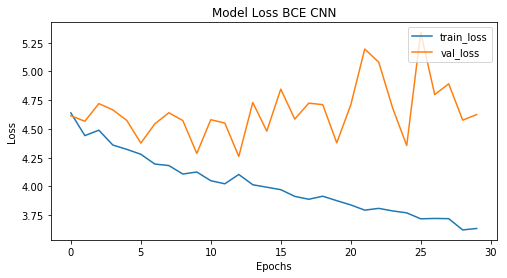

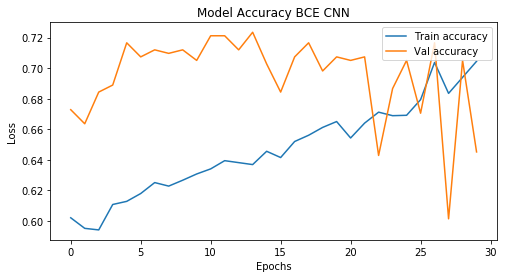

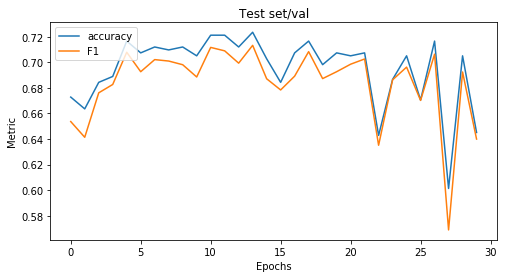

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.695841  0.721585  0.784330     0.722415       0.790073   
Confirmed       0.695841  0.721585  0.607353     0.722415       0.599419   

                Recall raw  
False Positive    0.778669  
Confirmed         0.615499

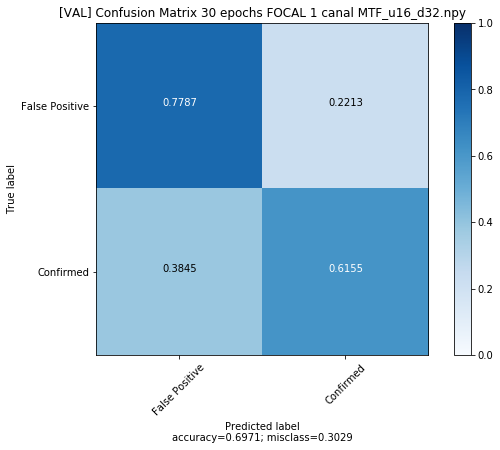

Entrenando usando representación 	Up: 32   Down: 32
 - val_f1: 0.662985 
 - val_f1: 0.663956 
 - val_f1: 0.661446 
 - val_f1: 0.685051 
 - val_f1: 0.703709 
 - val_f1: 0.647639 
 - val_f1: 0.702950 
 - val_f1: 0.671260 
 - val_f1: 0.689896 
 - val_f1: 0.701447 
 - val_f1: 0.692473 
 - val_f1: 0.715911 
 - val_f1: 0.718696 
 - val_f1: 0.707866 
 - val_f1: 0.705247 
 - val_f1: 0.698935 
 - val_f1: 0.699923 
 - val_f1: 0.691816 
 - val_f1: 0.702371 
 - val_f1: 0.708377 
 - val_f1: 0.701461 
 - val_f1: 0.695490 
 - val_f1: 0.714735 
 - val_f1: 0.698378 
 - val_f1: 0.712137 
 - val_f1: 0.718434 
 - val_f1: 0.703557 
 - val_f1: 0.707522 
 - val_f1: 0.718045 
 - val_f1: 0.713038 


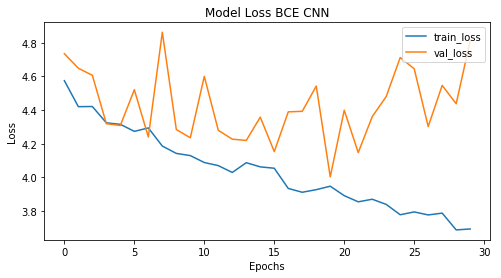

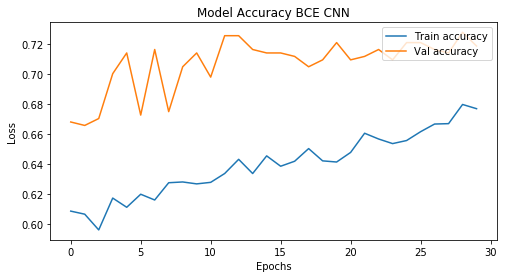

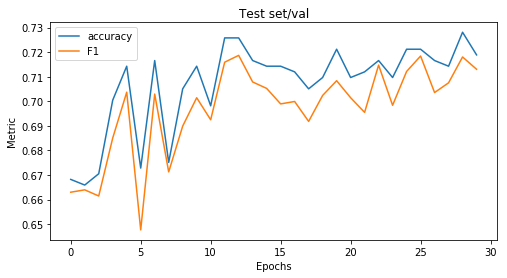

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.674888  0.676225  0.695737     0.681149       0.894207   
Confirmed       0.674888  0.676225  0.654039     0.681149       0.522242   

                Recall raw  
False Positive    0.569366  
Confirmed         0.874814

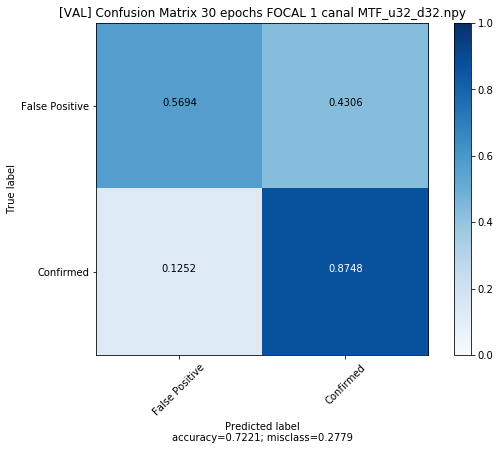

Entrenando usando representación 	Up: 10   Down: 10
 - val_f1: 0.670256 
 - val_f1: 0.588518 
 - val_f1: 0.674655 
 - val_f1: 0.680874 
 - val_f1: 0.693400 
 - val_f1: 0.711136 
 - val_f1: 0.676558 
 - val_f1: 0.706654 
 - val_f1: 0.696838 
 - val_f1: 0.716998 
 - val_f1: 0.710614 
 - val_f1: 0.700659 
 - val_f1: 0.705668 
 - val_f1: 0.713770 
 - val_f1: 0.720181 
 - val_f1: 0.710001 
 - val_f1: 0.721653 
 - val_f1: 0.683591 
 - val_f1: 0.713417 
 - val_f1: 0.710477 
 - val_f1: 0.717598 
 - val_f1: 0.698078 
 - val_f1: 0.596213 
 - val_f1: 0.706061 
 - val_f1: 0.645790 
 - val_f1: 0.700229 
 - val_f1: 0.693182 
 - val_f1: 0.683105 
 - val_f1: 0.706379 
 - val_f1: 0.675403 


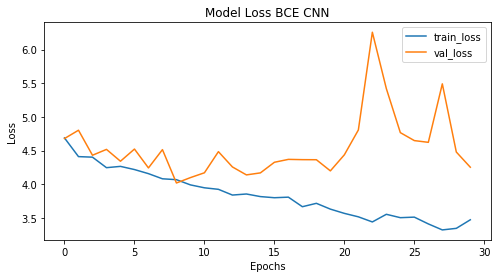

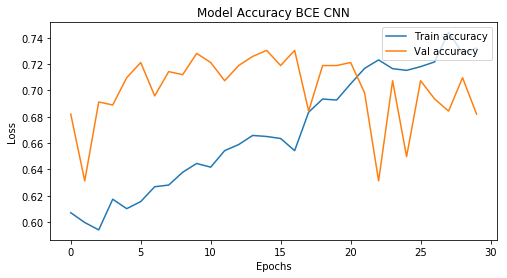

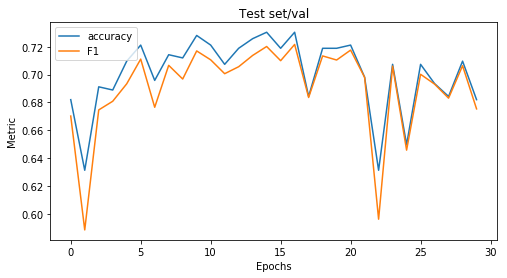

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.704533  0.737226  0.802817     0.734049       0.783804   
Confirmed       0.704533  0.737226  0.606250     0.734049       0.637110   

                Recall raw  
False Positive    0.822775  
Confirmed         0.578241

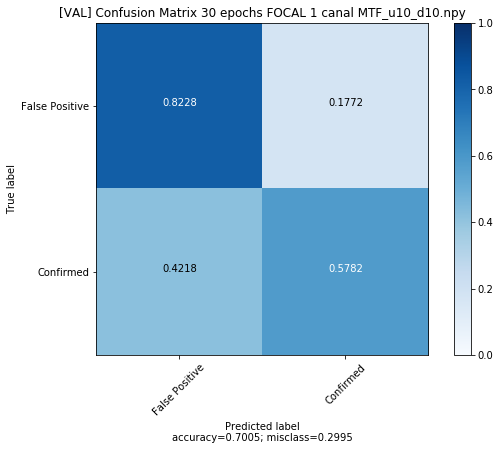

In [11]:
for data in os.listdir('../../../Data_PIIC/Datapi/no_inv/'):
    name= data.split('_')
    u= name[1][1:]
    d= name[2][1:].split('.')[0]
    print ("Entrenando usando representación \tUp:",u , '  Down:', d)
    channel_1 = np.load('../../../Data_PIIC/Datapi/no_inv/'+str(data)) 
    channel_2 = np.load('../../../Data_PIIC/Datapi/inv/'+str(data)) 
    x_all = np.asarray([np.dstack((channel_1[i],channel_2[i])) for i in range(channel_1.shape[0])])   
    x_train = x_all[mask_train]
    x_val = x_all[mask_test]
    if x_train.shape[0] < y_train.shape[0]:
        print ("\n\nVerificar dimensiones de objetos en",data)
        break

    a=int(u)+int(d)
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=(a,a,2), strides=(1, 1),activation="relu", padding="same"))
    model.add(MaxPooling2D((2,2)))
    #model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="same"))
    model.add(MaxPooling2D((2,2)))
    #model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="same"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="same"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    #model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    train_model(model, x_train, y_train, x_val, y_val, e=30, BS=64, focal=True, verbose=False)
    
    predichos=model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,title='[VAL] Confusion Matrix 30 epochs FOCAL 1 canal '+str(data)) 

In [13]:
cos=model.predict(x_val)

In [16]:
cas=model.predict_classes(x_val)

In [14]:
cos.shape

(1918, 1)

In [18]:
cos[:5]

array([[2.1615507e-01],
       [6.1927494e-08],
       [5.1415682e-01],
       [2.7970478e-01],
       [4.0059103e-04]], dtype=float32)

In [19]:
cas[:5]

array([[0],
       [0],
       [1],
       [0],
       [0]], dtype=int32)

## Un canal + tiempo

Entrenando usando representación 	Up: 15   Down: 15


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.510084 
 - val_f1: 0.562801 
 - val_f1: 0.361199 
 - val_f1: 0.695069 
 - val_f1: 0.469355 
 - val_f1: 0.690824 
 - val_f1: 0.697963 
 - val_f1: 0.514652 
 - val_f1: 0.590583 
 - val_f1: 0.571345 
 - val_f1: 0.483779 
 - val_f1: 0.484329 
 - val_f1: 0.478106 
 - val_f1: 0.582823 
 - val_f1: 0.521853 
 - val_f1: 0.383846 
 - val_f1: 0.504163 
 - val_f1: 0.532428 
 - val_f1: 0.608841 
 - val_f1: 0.685131 
 - val_f1: 0.555591 
 - val_f1: 0.668350 
 - val_f1: 0.590450 
 - val_f1: 0.569017 


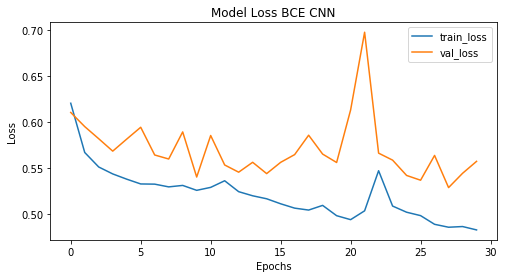

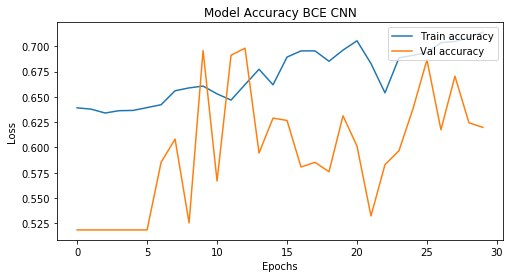

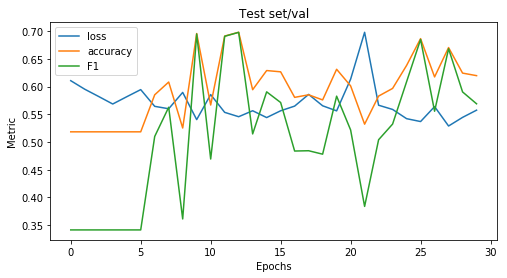

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.660559  0.741397  0.826209     0.710305       0.733665   
Confirmed       0.660559  0.741397  0.494908     0.710305       0.781350   

                Recall raw  
False Positive    0.945469  
Confirmed         0.362146

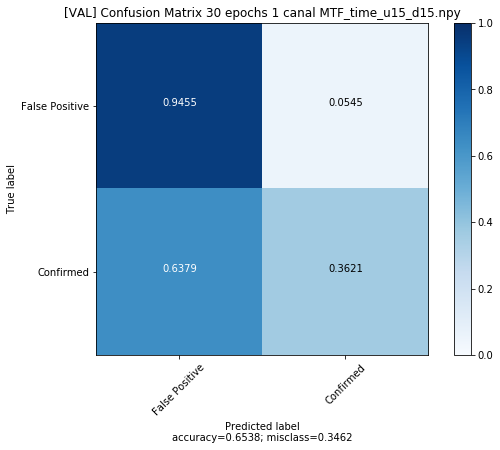

Entrenando usando representación 	Up: 15   Down: 30
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.578413 
 - val_f1: 0.356069 
 - val_f1: 0.357139 
 - val_f1: 0.434189 
 - val_f1: 0.341426 
 - val_f1: 0.437042 
 - val_f1: 0.613501 
 - val_f1: 0.465912 
 - val_f1: 0.572113 
 - val_f1: 0.616164 
 - val_f1: 0.532511 
 - val_f1: 0.598947 
 - val_f1: 0.610931 
 - val_f1: 0.448590 
 - val_f1: 0.697796 
 - val_f1: 0.503016 
 - val_f1: 0.482212 
 - val_f1: 0.502507 
 - val_f1: 0.677248 
 - val_f1: 0.553803 
 - val_f1: 0.570142 
 - val_f1: 0.515528 
 - val_f1: 0.619585 
 - val_f1: 0.601817 
 - val_f1: 0.598835 


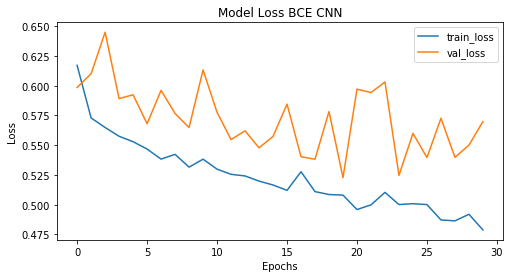

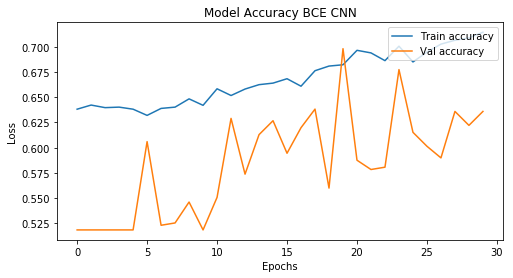

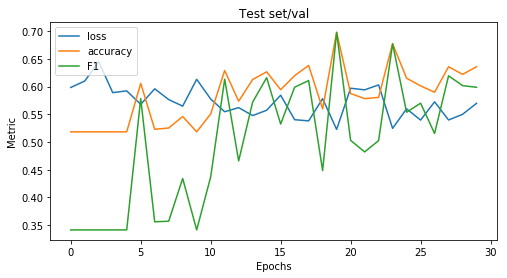

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.684204  0.739833  0.816746     0.724008       0.753388   
Confirmed       0.684204  0.739833  0.551662     0.724008       0.694570   

                Recall raw  
False Positive    0.891740  
Confirmed         0.457526

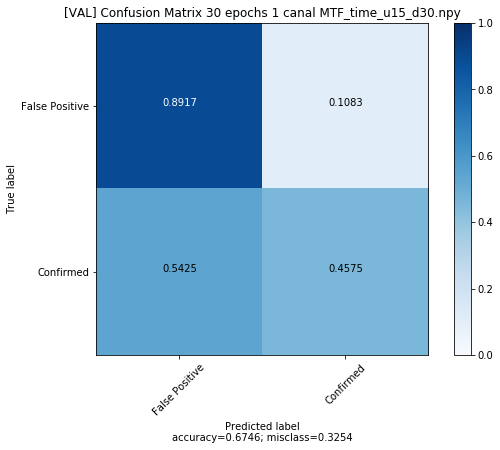

Entrenando usando representación 	Up: 32   Down: 32
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.696812 
 - val_f1: 0.403858 
 - val_f1: 0.683935 
 - val_f1: 0.704236 
 - val_f1: 0.361199 
 - val_f1: 0.422700 
 - val_f1: 0.704724 
 - val_f1: 0.366288 
 - val_f1: 0.399205 
 - val_f1: 0.369061 
 - val_f1: 0.426891 
 - val_f1: 0.713770 
 - val_f1: 0.714273 
 - val_f1: 0.415722 
 - val_f1: 0.494369 
 - val_f1: 0.731313 
 - val_f1: 0.702751 
 - val_f1: 0.493205 
 - val_f1: 0.600500 
 - val_f1: 0.591193 
 - val_f1: 0.499089 
 - val_f1: 0.499987 
 - val_f1: 0.711723 
 - val_f1: 0.603049 
 - val_f1: 0.592370 
 - val_f1: 0.489452 


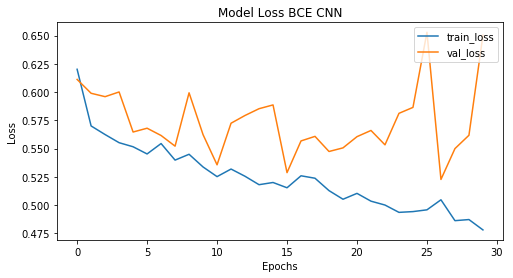

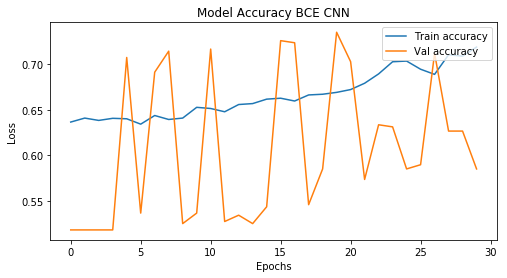

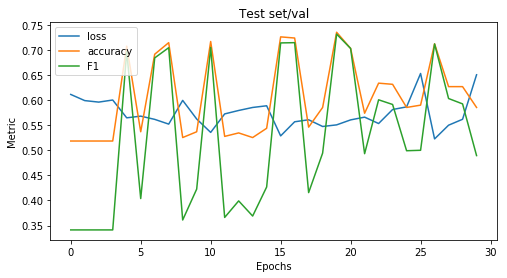

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.557511   0.70438  0.812438     0.634068       0.691441   
Confirmed       0.557511   0.70438  0.302583     0.634068       0.866197   

                Recall raw  
False Positive    0.984763  
Confirmed         0.183308

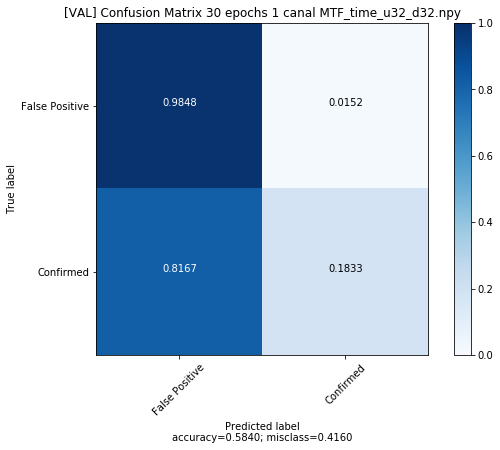

Entrenando usando representación 	Up: 10   Down: 10
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.341426 
 - val_f1: 0.411733 
 - val_f1: 0.658399 
 - val_f1: 0.341426 
 - val_f1: 0.626316 
 - val_f1: 0.712741 
 - val_f1: 0.405154 
 - val_f1: 0.465235 
 - val_f1: 0.594115 
 - val_f1: 0.693508 
 - val_f1: 0.600819 
 - val_f1: 0.587608 
 - val_f1: 0.691238 
 - val_f1: 0.500329 
 - val_f1: 0.671023 
 - val_f1: 0.508569 
 - val_f1: 0.686396 
 - val_f1: 0.537669 
 - val_f1: 0.528644 
 - val_f1: 0.550237 
 - val_f1: 0.572046 
 - val_f1: 0.639592 
 - val_f1: 0.612850 
 - val_f1: 0.518908 
 - val_f1: 0.572698 
 - val_f1: 0.599959 
 - val_f1: 0.589293 


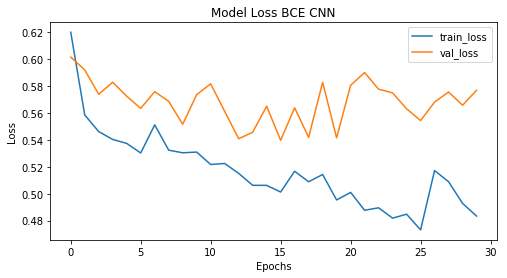

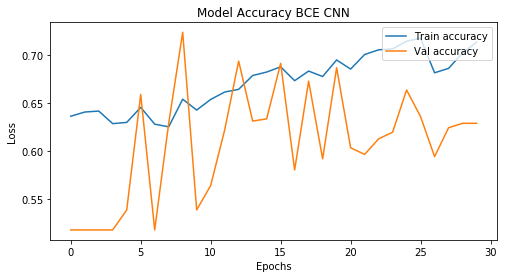

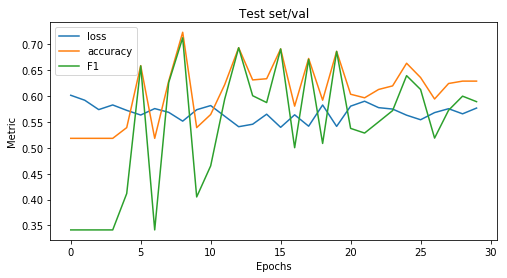

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.636325  0.714807  0.805269     0.687061       0.724072   
Confirmed       0.636325  0.714807  0.467381     0.687061       0.674157   

                Recall raw  
False Positive    0.906977  
Confirmed         0.357675

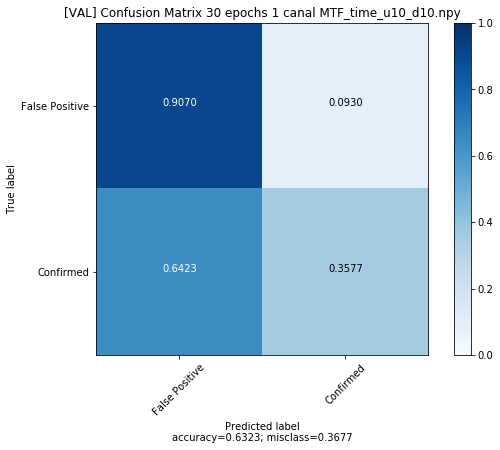

In [22]:
for data in os.listdir('../../../Data_PIIC/Datapi/time/'):
    name= data.split('_')
    u= name[2][1:]
    d= name[3][1:].split('.')[0]
    print ("Entrenando usando representación \tUp:",u , '  Down:', d)
    channel_1 = np.load('../../../Data_PIIC/Datapi/no_inv/'+str(data[:3])+str(data[8:])) 
    channel_2 = np.load('../../../Data_PIIC/Datapi/time/'+str(data)) 
    x_all = np.asarray([np.dstack((channel_1[i],channel_2[i])) for i in range(channel_1.shape[0])])   
    x_train = x_all[mask_train]
    x_val = x_all[mask_test]
    if x_train.shape[0] < y_train.shape[0]:
        print ("\n\nVerificar dimensiones de objetos en",data)
        break

    a=int(u)+int(d)
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=(a,a,2), strides=(1, 1),activation="relu", padding="same"))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="same"))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="same"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="same"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    train_model(model, x_train, y_train, x_val, y_val, e=30, BS=64, verbose=False)
    
    predichos=model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,title='[VAL] Confusion Matrix 30 epochs 1 canal '+str(data)) 

Entrenando usando representación 	Up: 15   Down: 15
 - val_f1: 0.660824 
 - val_f1: 0.659811 
 - val_f1: 0.687001 
 - val_f1: 0.702621 
 - val_f1: 0.645727 
 - val_f1: 0.710001 
 - val_f1: 0.695945 
 - val_f1: 0.701447 
 - val_f1: 0.700843 
 - val_f1: 0.702035 
 - val_f1: 0.668196 
 - val_f1: 0.695057 
 - val_f1: 0.703791 
 - val_f1: 0.715911 
 - val_f1: 0.708796 
 - val_f1: 0.710087 
 - val_f1: 0.711647 
 - val_f1: 0.711647 
 - val_f1: 0.708647 
 - val_f1: 0.724151 
 - val_f1: 0.702804 
 - val_f1: 0.723797 
 - val_f1: 0.716410 
 - val_f1: 0.710493 
 - val_f1: 0.694876 
 - val_f1: 0.713777 
 - val_f1: 0.725942 
 - val_f1: 0.696018 
 - val_f1: 0.709526 
 - val_f1: 0.739942 


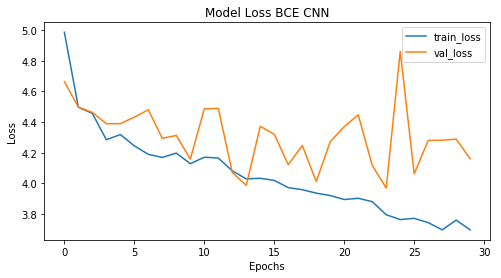

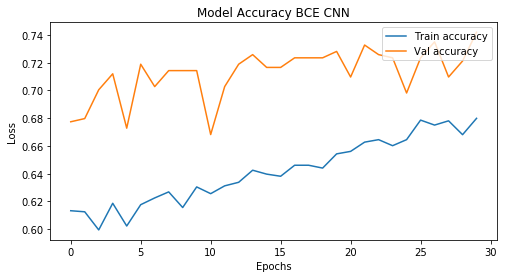

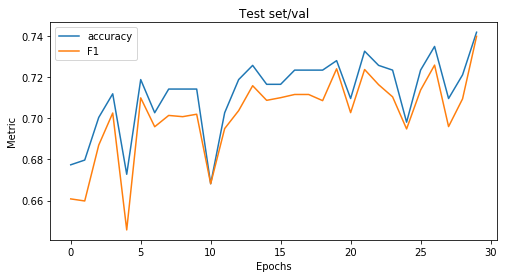

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.698289  0.700209  0.722356     0.705516       0.907767   
Confirmed       0.698289  0.700209  0.674221     0.705516       0.543876   

                Recall raw  
False Positive    0.599840  
Confirmed         0.886736

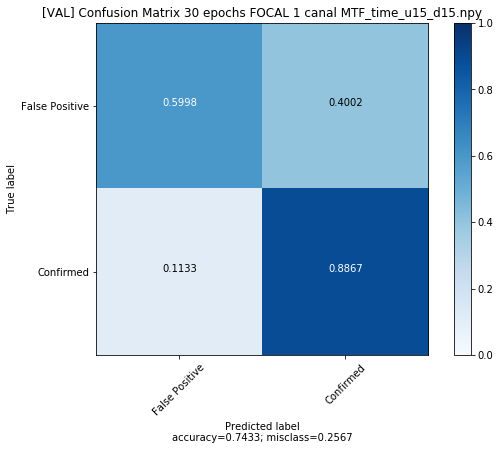

Entrenando usando representación 	Up: 15   Down: 30
 - val_f1: 0.659333 
 - val_f1: 0.669139 
 - val_f1: 0.671968 
 - val_f1: 0.699466 
 - val_f1: 0.643728 
 - val_f1: 0.694591 
 - val_f1: 0.699923 
 - val_f1: 0.657564 
 - val_f1: 0.677323 
 - val_f1: 0.687136 
 - val_f1: 0.685746 
 - val_f1: 0.676839 
 - val_f1: 0.703709 
 - val_f1: 0.692647 
 - val_f1: 0.705285 
 - val_f1: 0.694079 
 - val_f1: 0.706362 
 - val_f1: 0.689908 
 - val_f1: 0.685856 
 - val_f1: 0.710001 
 - val_f1: 0.695490 
 - val_f1: 0.700362 
 - val_f1: 0.702950 
 - val_f1: 0.717529 
 - val_f1: 0.717356 
 - val_f1: 0.714327 
 - val_f1: 0.697577 
 - val_f1: 0.716998 
 - val_f1: 0.715893 
 - val_f1: 0.709893 


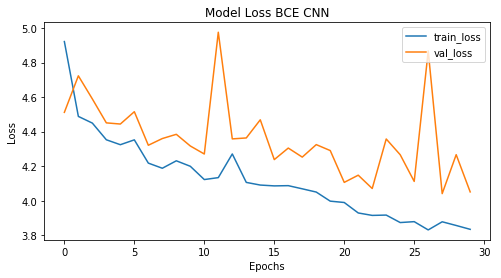

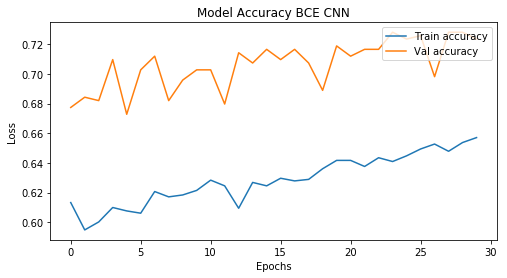

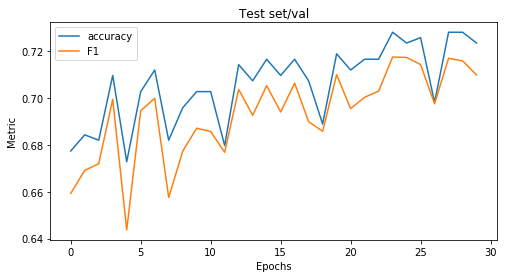

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.648758  0.649114  0.637588     0.645404       0.970492   
Confirmed       0.648758  0.649114  0.659929     0.645404       0.499235   

                Recall raw  
False Positive    0.474739  
Confirmed         0.973174

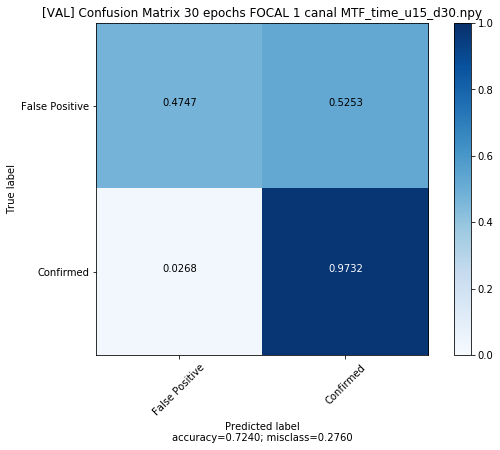

Entrenando usando representación 	Up: 32   Down: 32
 - val_f1: 0.660824 
 - val_f1: 0.620306 
 - val_f1: 0.678625 
 - val_f1: 0.678388 
 - val_f1: 0.671968 
 - val_f1: 0.699466 
 - val_f1: 0.681588 
 - val_f1: 0.696812 
 - val_f1: 0.671240 
 - val_f1: 0.705285 
 - val_f1: 0.705831 
 - val_f1: 0.652730 
 - val_f1: 0.704724 
 - val_f1: 0.709671 
 - val_f1: 0.699466 
 - val_f1: 0.685519 
 - val_f1: 0.708464 
 - val_f1: 0.700223 
 - val_f1: 0.652072 
 - val_f1: 0.708284 
 - val_f1: 0.685675 
 - val_f1: 0.718547 
 - val_f1: 0.721268 
 - val_f1: 0.709579 
 - val_f1: 0.683629 
 - val_f1: 0.710493 
 - val_f1: 0.710878 
 - val_f1: 0.686310 
 - val_f1: 0.746199 
 - val_f1: 0.706082 


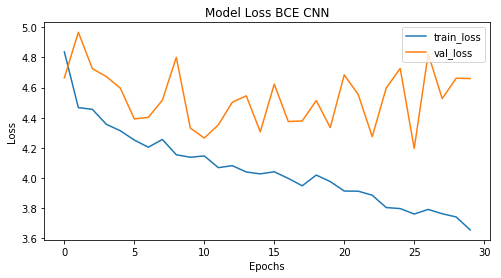

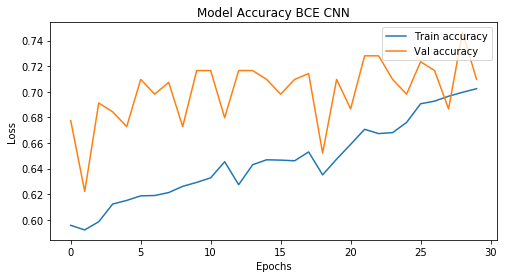

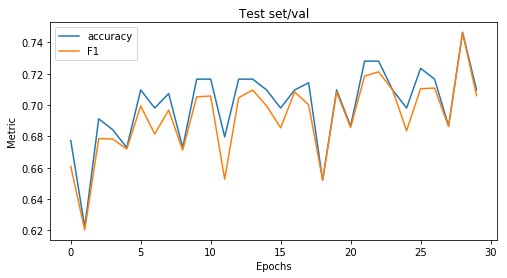

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.686142  0.687174  0.704142     0.691547       0.914213   
Confirmed       0.686142  0.687174  0.668142     0.691547       0.531223   

                Recall raw  
False Positive    0.572574  
Confirmed         0.900149

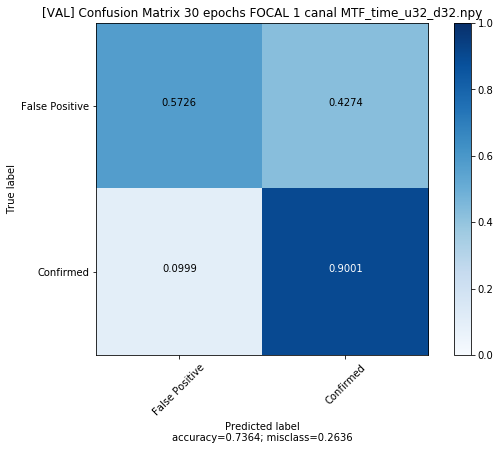

Entrenando usando representación 	Up: 10   Down: 10
 - val_f1: 0.675588 
 - val_f1: 0.704236 
 - val_f1: 0.702111 
 - val_f1: 0.635676 
 - val_f1: 0.697487 
 - val_f1: 0.708377 
 - val_f1: 0.693591 
 - val_f1: 0.710077 
 - val_f1: 0.683480 
 - val_f1: 0.708377 
 - val_f1: 0.687101 
 - val_f1: 0.714273 
 - val_f1: 0.693400 
 - val_f1: 0.696838 
 - val_f1: 0.691659 
 - val_f1: 0.685746 
 - val_f1: 0.713417 
 - val_f1: 0.688533 
 - val_f1: 0.706262 
 - val_f1: 0.698120 
 - val_f1: 0.695701 
 - val_f1: 0.638323 
 - val_f1: 0.711644 
 - val_f1: 0.671023 
 - val_f1: 0.715911 
 - val_f1: 0.651882 
 - val_f1: 0.660163 
 - val_f1: 0.707522 
 - val_f1: 0.696018 
 - val_f1: 0.691983 


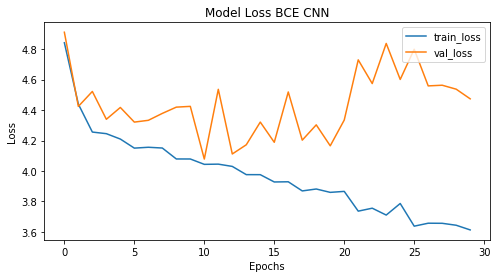

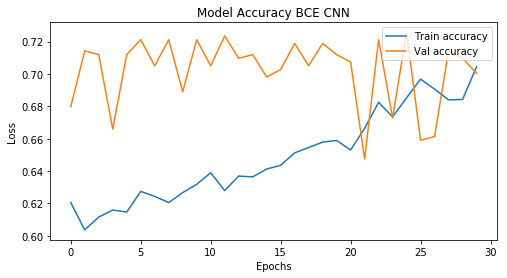

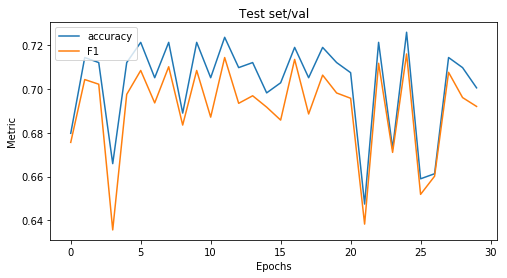

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.668058  0.668405  0.678788      0.67128       0.916780   
Confirmed       0.668058  0.668405  0.657328      0.67128       0.514768   

                Recall raw  
False Positive    0.538893  
Confirmed         0.909091

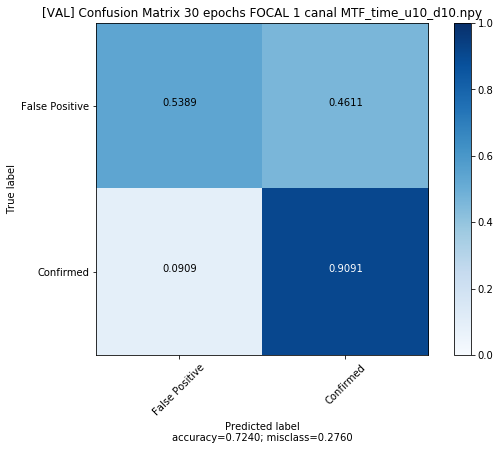

In [23]:
for data in os.listdir('../../../Data_PIIC/Datapi/time/'):
    name= data.split('_')
    u= name[2][1:]
    d= name[3][1:].split('.')[0]
    print ("Entrenando usando representación \tUp:",u , '  Down:', d)
    channel_1 = np.load('../../../Data_PIIC/Datapi/no_inv/'+str(data[:3])+str(data[8:])) 
    channel_2 = np.load('../../../Data_PIIC/Datapi/time/'+str(data)) 
    x_all = np.asarray([np.dstack((channel_1[i],channel_2[i])) for i in range(channel_1.shape[0])])   
    x_train = x_all[mask_train]
    x_val = x_all[mask_test]
    if x_train.shape[0] < y_train.shape[0]:
        print ("\n\nVerificar dimensiones de objetos en",data)
        break
        
    a=int(u)+int(d)
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=(a,a,2), strides=(1, 1),activation="relu", padding="same"))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="same"))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="same"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="same"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    train_model(model, x_train, y_train, x_val, y_val, e=30, BS=64, focal=True, verbose=False)
    
    predichos=model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,title='[VAL] Confusion Matrix 30 epochs FOCAL 1 canal '+str(data)) 